In [30]:
# Normal 클래스 디버깅
import os

root_dir = './COVID-19_Radiography_Dataset'
class_name = 'Normal'

# 1. 폴더 확인
images_path = os.path.join(root_dir, class_name, 'images')
masks_path = os.path.join(root_dir, class_name, 'masks')

print(f"Images 폴더 존재: {os.path.exists(images_path)}")
print(f"Masks 폴더 존재: {os.path.exists(masks_path)}")

if os.path.exists(images_path):
    print(f"Images 파일 수: {len(os.listdir(images_path))}")
    
if os.path.exists(masks_path):
    print(f"Masks 파일 수: {len(os.listdir(masks_path))}")
    # 첫 번째 마스크 확인
    mask_files = [f for f in os.listdir(masks_path) if f.endswith('.png')]
    if mask_files:
        first_mask = cv2.imread(os.path.join(masks_path, mask_files[0]), cv2.IMREAD_GRAYSCALE)
        print(f"첫 번째 마스크 크기: {first_mask.shape}")
        print(f"마스크 값 범위: {first_mask.min()} ~ {first_mask.max()}")

Images 폴더 존재: True
Masks 폴더 존재: True
Images 파일 수: 10192
Masks 파일 수: 10192
첫 번째 마스크 크기: (256, 256)
마스크 값 범위: 0 ~ 255


분석 대상: COVID - COVID-1145
기록된 boundary_touch: True
품질 점수: 75.0

마스크 크기: (299, 299)
경계 터치 분석:
  Top: False
  Bottom: False
  Left: False
  Right: True
  전체: True

경계 픽셀 개수:
  Top: 0/299
  Bottom: 0/299
  Left: 0/299
  Right: 120/299


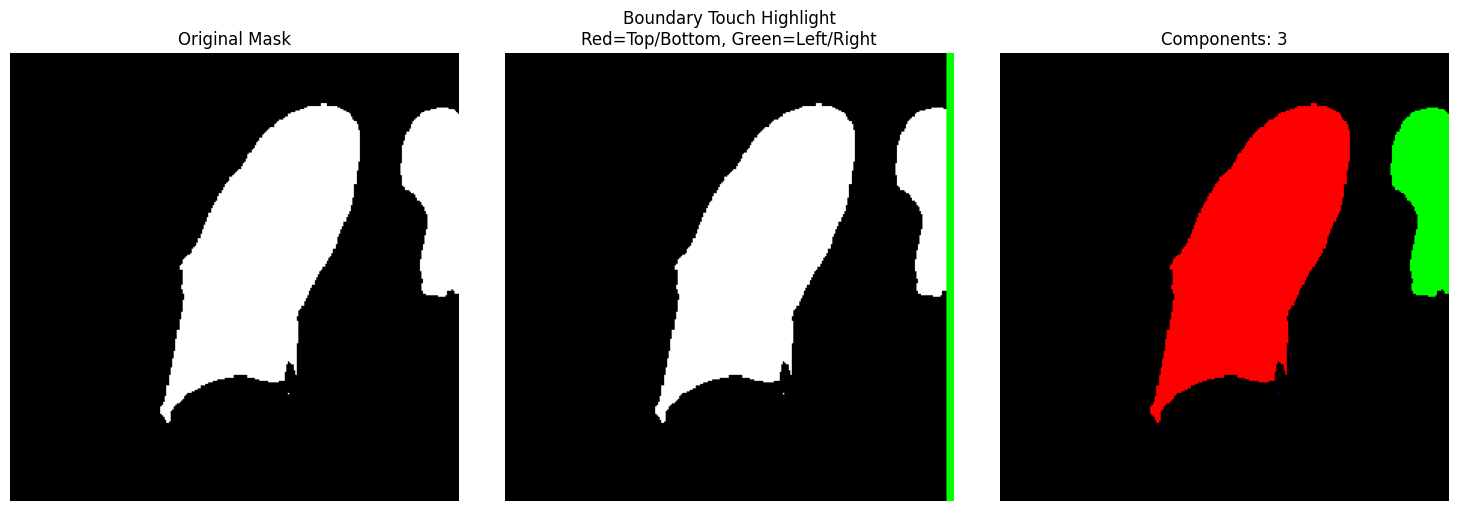

In [37]:
# 특정 샘플 재확인
def debug_boundary_touch(eda, class_name, image_name):
    """특정 샘플의 경계 터치 상세 분석"""
    
    image, mask = eda.load_image_and_mask(class_name, image_name)
    
    if image is None or mask is None:
        print("이미지 로드 실패")
        return
    
    h, w = mask.shape
    
    # 경계 체크
    top = np.any(mask[0, :] > 0)
    bottom = np.any(mask[-1, :] > 0)
    left = np.any(mask[:, 0] > 0)
    right = np.any(mask[:, -1] > 0)
    
    print(f"마스크 크기: {mask.shape}")
    print(f"경계 터치 분석:")
    print(f"  Top: {top}")
    print(f"  Bottom: {bottom}")
    print(f"  Left: {left}")
    print(f"  Right: {right}")
    print(f"  전체: {top or bottom or left or right}")
    
    # 경계 픽셀 개수
    top_pixels = np.sum(mask[0, :] > 0)
    bottom_pixels = np.sum(mask[-1, :] > 0)
    left_pixels = np.sum(mask[:, 0] > 0)
    right_pixels = np.sum(mask[:, -1] > 0)
    
    print(f"\n경계 픽셀 개수:")
    print(f"  Top: {top_pixels}/{w}")
    print(f"  Bottom: {bottom_pixels}/{w}")
    print(f"  Left: {left_pixels}/{h}")
    print(f"  Right: {right_pixels}/{h}")
    
    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 원본 마스크
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('Original Mask')
    axes[0].axis('off')
    
    # 경계 강조
    boundary_highlight = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    if top:
        boundary_highlight[0:5, :] = [255, 0, 0]  # 빨강
    if bottom:
        boundary_highlight[-5:, :] = [255, 0, 0]
    if left:
        boundary_highlight[:, 0:5] = [0, 255, 0]  # 초록
    if right:
        boundary_highlight[:, -5:] = [0, 255, 0]
    
    axes[1].imshow(boundary_highlight)
    axes[1].set_title('Boundary Touch Highlight\nRed=Top/Bottom, Green=Left/Right')
    axes[1].axis('off')
    
    # 컴포넌트 분석
    num_components, labeled_mask, _ = eda.analyze_connected_components(mask)
    
    colored_components = np.zeros((*mask.shape, 3), dtype=np.uint8)
    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]]
    
    for comp_id in range(1, num_components + 1):
        color = colors[(comp_id - 1) % len(colors)]
        colored_components[labeled_mask == comp_id] = color
    
    axes[2].imshow(colored_components)
    axes[2].set_title(f'Components: {num_components}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


# 3개 컴포넌트 샘플 중 하나 확인
abnormal = eda.df_results[eda.df_results['num_components'] >= 3].head(1)
if len(abnormal) > 0:
    sample = abnormal.iloc[0]
    print(f"분석 대상: {sample['class']} - {sample['image_name']}")
    print(f"기록된 boundary_touch: {sample['has_boundary_touch']}")
    print(f"품질 점수: {sample['mask_quality_score']}\n")
    
    debug_boundary_touch(eda, sample['class'], sample['image_name'])

In [18]:
def visualize_abnormal_components(eda, save_dir='segmentation_eda_results'):
    """비정상적인 컴포넌트 개수를 가진 샘플 시각화"""
    os.makedirs(save_dir, exist_ok=True)
    
    df = eda.df_results
    
    # 3개 이상 컴포넌트를 가진 샘플 필터링
    abnormal = df[df['num_components'] >= 3].sort_values('num_components', ascending=False)
    
    print(f"\n3개 이상 컴포넌트를 가진 샘플: {len(abnormal)}개")
    print(abnormal[['class', 'image_name', 'num_components', 'mask_quality_score']].head(10))
    
    if len(abnormal) == 0:
        print("3개 이상 컴포넌트 샘플이 없습니다.")
        return
    
    # 전체 이상치 파일명 리스트 먼저 저장
    all_txt_path = os.path.join(save_dir, 'abnormal_components_ALL.txt')
    abnormal['image_name'].to_csv(all_txt_path, index=False, header=False, encoding='utf-8')
    print(f"✓ 전체 이상치 파일명 저장: {all_txt_path} ({len(abnormal)}개)")
    
    # 클래스별로 최대 3개씩 시각화
    for class_name in eda.classes:
        class_abnormal = abnormal[abnormal['class'] == class_name]
        
        if len(class_abnormal) == 0:
            continue
        
        # 클래스별 파일명 리스트 저장
        class_txt_path = os.path.join(save_dir, f'abnormal_components_{class_name}_list.txt')
        class_abnormal['image_name'].to_csv(class_txt_path, index=False, header=False, encoding='utf-8')
        print(f"  → {class_name} 파일명 저장: {class_txt_path} ({len(class_abnormal)}개)")
        
        # 최대 3개 선택 (시각화용)
        samples_to_show = class_abnormal.head(3)
        
        fig, axes = plt.subplots(len(samples_to_show), 4, figsize=(20, 5 * len(samples_to_show)))
        
        if len(samples_to_show) == 1:
            axes = axes.reshape(1, -1)
        
        for i, (idx, sample) in enumerate(samples_to_show.iterrows()):
            file_name = sample['image_name']
            
            # 이미지와 마스크 로드
            image, mask = eda.load_image_and_mask(class_name, file_name)
            
            if image is None or mask is None:
                continue
            
            # 연결 컴포넌트 분석
            num_components, labeled_mask, left_right_ratio = eda.analyze_connected_components(mask)
            
            # 컴포넌트별 색상 지정
            colored_components = np.zeros((*mask.shape, 3), dtype=np.uint8)
            colors = [
                [255, 0, 0],    # Red
                [0, 255, 0],    # Green
                [0, 0, 255],    # Blue
                [255, 255, 0],  # Yellow
                [255, 0, 255],  # Magenta
                [0, 255, 255],  # Cyan
            ]
            
            for comp_id in range(1, num_components + 1):
                color = colors[(comp_id - 1) % len(colors)]
                colored_components[labeled_mask == comp_id] = color
            
            # 오버레이
            overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            blended = cv2.addWeighted(overlay, 0.6, colored_components, 0.4, 0)
            
            # 1. 원본 이미지
            axes[i, 0].imshow(image, cmap='gray')
            axes[i, 0].set_title(f'Original\n{file_name[:20]}...', fontsize=10)
            axes[i, 0].axis('off')
            
            # 2. 마스크
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title(f'Mask\nComponents: {num_components}', fontsize=10)
            axes[i, 1].axis('off')
            
            # 3. 컴포넌트별 색상 구분
            axes[i, 2].imshow(colored_components)
            axes[i, 2].set_title(f'Components (Colored)\nQuality: {sample["mask_quality_score"]:.1f}', fontsize=10)
            axes[i, 2].axis('off')
            
            # 4. 오버레이
            axes[i, 3].imshow(blended)
            axes[i, 3].set_title(f'Overlay\nL/R Ratio: {left_right_ratio:.2f}', fontsize=10)
            axes[i, 3].axis('off')
        
        plt.suptitle(f'{class_name} - Samples with 3+ Components', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'abnormal_components_{class_name}.png'), dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"  ✓ {class_name}: {len(samples_to_show)}개 샘플 시각화 완료")
    
    print(f"\n비정상 컴포넌트 시각화 완료! '{save_dir}' 폴더 확인")


def visualize_single_component(eda, save_dir='segmentation_eda_results'):
    """1개 컴포넌트만 있는 샘플 시각화 (한쪽 폐만 분할된 경우)"""
    os.makedirs(save_dir, exist_ok=True)
    
    df = eda.df_results
    
    # 1개 컴포넌트만 있는 샘플
    single = df[df['num_components'] == 1]
    
    print(f"\n1개 컴포넌트만 있는 샘플: {len(single)}개")
    print(single[['class', 'image_name', 'num_components', 'mask_quality_score']].head(10))
    
    if len(single) == 0:
        print("1개 컴포넌트 샘플이 없습니다.")
        return
    
    # 전체 single component 파일명 리스트 먼저 저장
    all_txt_path = os.path.join(save_dir, 'single_component_ALL.txt')
    single['image_name'].to_csv(all_txt_path, index=False, header=False, encoding='utf-8')
    print(f"✓ 전체 single component 파일명 저장: {all_txt_path} ({len(single)}개)")
    
    # 클래스별로 최대 3개씩 시각화
    for class_name in eda.classes:
        class_single = single[single['class'] == class_name]
        
        if len(class_single) == 0:
            continue
        
        # 클래스별 파일명 리스트 저장
        class_txt_path = os.path.join(save_dir, f'single_component_{class_name}_list.txt')
        class_single['image_name'].to_csv(class_txt_path, index=False, header=False, encoding='utf-8')
        print(f"  → {class_name} 파일명 저장: {class_txt_path} ({len(class_single)}개)")
        
        samples_to_show = class_single.head(3)
        
        fig, axes = plt.subplots(len(samples_to_show), 3, figsize=(15, 5 * len(samples_to_show)))
        
        if len(samples_to_show) == 1:
            axes = axes.reshape(1, -1)
        
        for i, (idx, sample) in enumerate(samples_to_show.iterrows()):
            file_name = sample['image_name']
            
            image, mask = eda.load_image_and_mask(class_name, file_name)
            
            if image is None or mask is None:
                continue
            
            overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            overlay[mask > 0] = [255, 0, 0]  # Red
            blended = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), 0.7, overlay, 0.3, 0)
            
            axes[i, 0].imshow(image, cmap='gray')
            axes[i, 0].set_title(f'Original', fontsize=10)
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title(f'Mask (Only 1 Lung)\nQuality: {sample["mask_quality_score"]:.1f}', fontsize=10)
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(blended)
            axes[i, 2].set_title(f'Overlay\nArea: {sample["mask_area_ratio"]:.2%}', fontsize=10)
            axes[i, 2].axis('off')
        
        plt.suptitle(f'{class_name} - Single Component (Only One Lung)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'single_component_{class_name}.png'), dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"  ✓ {class_name}: {len(samples_to_show)}개 샘플 시각화 완료")
    
    print(f"\n단일 컴포넌트 시각화 완료! '{save_dir}' 폴더 확인")


# 실행
visualize_abnormal_components(eda, save_dir='segmentation_eda_results')
visualize_single_component(eda, save_dir='segmentation_eda_results')


3개 이상 컴포넌트를 가진 샘플: 269개
             class         image_name  num_components  mask_quality_score
1745         COVID          COVID-257               7                40.0
2604         COVID         COVID-3342               7                95.0
5513  Lung_Opacity  Lung_Opacity-2706               5                55.0
5346  Lung_Opacity  Lung_Opacity-2556               5                40.0
790          COVID          COVID-171               5                95.0
8496  Lung_Opacity  Lung_Opacity-5391               5                80.0
2253         COVID         COVID-3026               4                80.0
6040  Lung_Opacity  Lung_Opacity-3180               4                95.0
6164  Lung_Opacity  Lung_Opacity-3292               4                40.0
9005  Lung_Opacity   Lung_Opacity-585               4                50.0
✓ 전체 이상치 파일명 저장: segmentation_eda_results/abnormal_components_ALL.txt (269개)
  → COVID 파일명 저장: segmentation_eda_results/abnormal_components_COVID_list.txt (74개)


폐 Segmentation 데이터 분석 시작

[COVID] 분석 중...
  📁 총 3616개 파일 발견
  ✓ 성공: 3616개 | ✗ 실패: 0개

[Lung_Opacity] 분석 중...
  📁 총 6012개 파일 발견
  ✓ 성공: 6012개 | ✗ 실패: 0개

[Normal] 분석 중...
  📁 총 10192개 파일 발견
  ✓ 성공: 10192개 | ✗ 실패: 0개

[Viral Pneumonia] 분석 중...
  📁 총 1521개 파일 발견
  ✓ 성공: 1345개 | ✗ 실패: 176개

전체 분석 완료: 21165개 샘플

요약 통계

[COVID]
  샘플 수: 3616
  마스크 면적 비율: 0.244 ± 0.073
  평균 컴포넌트 개수: 2.02
  좌우 비율: 0.830 ± 0.103
  평균 품질 점수: 96.7
  경계 터치 비율: 10.5%
  대비 비율: 0.465

[Lung_Opacity]
  샘플 수: 6012
  마스크 면적 비율: 0.215 ± 0.055
  평균 컴포넌트 개수: 2.02
  좌우 비율: 0.791 ± 0.126
  평균 품질 점수: 95.5
  경계 터치 비율: 4.9%
  대비 비율: 0.280

[Normal]
  샘플 수: 10192
  마스크 면적 비율: 0.252 ± 0.058
  평균 컴포넌트 개수: 2.01
  좌우 비율: 0.839 ± 0.088
  평균 품질 점수: 98.4
  경계 터치 비율: 2.3%
  대비 비율: 0.491

[Viral Pneumonia]
  샘플 수: 1345
  마스크 면적 비율: 0.233 ± 0.051
  평균 컴포넌트 개수: 2.01
  좌우 비율: 0.699 ± 0.125
  평균 품질 점수: 89.6
  경계 터치 비율: 14.5%
  대비 비율: 0.193

저품질 마스크 탐지 (품질 점수 < 50)
저품질 마스크: 18개 (0.1%)
  COVID: 8개
  Lung_Opacity: 6개
  Normal: 2개
  Viral Pneumon

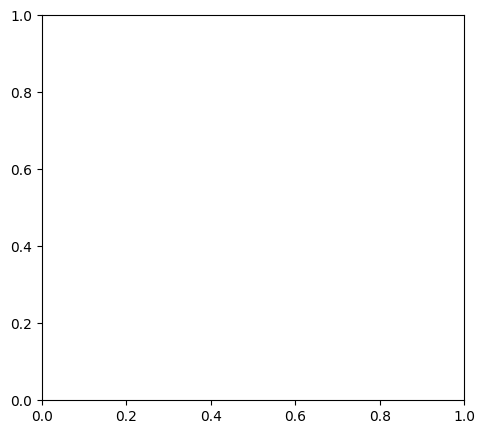

<Figure size 1000x500 with 0 Axes>

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy import ndimage
from skimage import measure, morphology
from sklearn.metrics import jaccard_score
import warnings
warnings.filterwarnings('ignore')


class LungSegmentationEDA:
    """폐 Segmentation 데이터 분석 클래스"""
    
    def __init__(self, root_dir):
        """
        Args:
            root_dir: 데이터셋 루트 경로 (COVID-19_Radiography_Dataset)
        """
        self.root_dir = root_dir
        self.classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
        self.results = {
            'class': [],
            'image_name': [],
            'mask_area_ratio': [],
            'num_components': [],
            'left_right_ratio': [],
            'mask_quality_score': [],
            'edge_smoothness': [],
            'has_boundary_touch': [],
            'aspect_ratio': [],
            'mean_intensity_inside': [],
            'mean_intensity_outside': [],
            'std_intensity_inside': [],
            'std_intensity_outside': [],
            'contrast_ratio': []
        }
    
    def load_image_and_mask(self, class_name, file_name):
        """이미지와 마스크 로드"""
        # 이미지 경로
        img_path = os.path.join(self.root_dir, class_name, 'images', f'{file_name}.png')
        mask_path = os.path.join(self.root_dir, class_name, 'masks', f'{file_name}.png')
        
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            return None, None
        
        # 이미지 로드
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None or mask is None:
            return None, None
        
        # ★★★ 마스크를 이미지 크기에 맞게 리사이즈 ★★★
        if image.shape != mask.shape:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        # 마스크 이진화 (0 또는 255)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        return image, mask
    
    def analyze_connected_components(self, mask):
        """연결된 컴포넌트 분석 (좌/우 폐 구분)"""
        # 연결된 영역 찾기
        labeled_mask, num_components = ndimage.label(mask > 0)
        
        if num_components == 0:
            return 0, 0, 1.0
        
        # 각 컴포넌트의 크기 계산
        component_sizes = []
        for i in range(1, num_components + 1):
            size = np.sum(labeled_mask == i)
            component_sizes.append(size)
        
        component_sizes.sort(reverse=True)
        
        # 좌우 폐 비율 (가장 큰 2개 영역)
        if len(component_sizes) >= 2:
            left_right_ratio = min(component_sizes[0], component_sizes[1]) / max(component_sizes[0], component_sizes[1])
        else:
            left_right_ratio = 1.0 if len(component_sizes) == 1 else 0.0
        
        return num_components, labeled_mask, left_right_ratio
    
    def calculate_edge_smoothness(self, mask):
        """경계선 부드러움 측정"""
        # Canny edge detection
        edges = cv2.Canny(mask, 50, 150)
        
        # 경계선 픽셀 수
        edge_pixels = np.sum(edges > 0)
        
        # 마스크 영역의 둘레
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        if len(contours) == 0:
            return 0.0
        
        perimeter = sum([cv2.arcLength(cnt, True) for cnt in contours])
        
        # 면적
        area = np.sum(mask > 0)
        
        if area == 0:
            return 0.0
        
        # Circularity (1에 가까울수록 원에 가까움)
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter ** 2)
        else:
            circularity = 0.0
        
        return circularity
    
    def check_boundary_touch(self, mask):
        """마스크가 이미지 경계에 닿는지 확인"""
        h, w = mask.shape
        
        # 상하좌우 경계 체크
        top = np.any(mask[0, :] > 0)
        bottom = np.any(mask[-1, :] > 0)
        left = np.any(mask[:, 0] > 0)
        right = np.any(mask[:, -1] > 0)
        
        return top or bottom or left or right
    
    def calculate_intensity_stats(self, image, mask):
        """폐 영역 내부/외부 픽셀 분포 분석"""
        # ★★★ 크기 체크 추가 ★★★
        if image.shape != mask.shape:
            print(f"Warning: Image shape {image.shape} != Mask shape {mask.shape}")
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        inside_pixels = image[mask > 0]
        outside_pixels = image[mask == 0]
        
        if len(inside_pixels) == 0 or len(outside_pixels) == 0:
            return 0, 0, 0, 0, 1.0
        
        mean_inside = np.mean(inside_pixels)
        std_inside = np.std(inside_pixels)
        mean_outside = np.mean(outside_pixels)
        std_outside = np.std(outside_pixels)
        
        # 대비 비율 (높을수록 폐 영역이 명확히 구분됨)
        contrast_ratio = abs(mean_inside - mean_outside) / (std_inside + std_outside + 1e-6)
        
        return mean_inside, std_inside, mean_outside, std_outside, contrast_ratio
    
    def calculate_mask_quality_score(self, num_components, left_right_ratio, 
                                     edge_smoothness, has_boundary_touch, 
                                     mask_area_ratio, aspect_ratio):
        """마스크 품질 점수 계산 (0~100)"""
        score = 100.0
        
        # 1. 컴포넌트 개수 (2개가 이상적)
        if num_components < 1:
            score -= 50
        elif num_components > 3:
            score -= 20
        elif num_components == 2:
            score += 10
        
        # 2. 좌우 비율 (0.7~1.3이 정상)
        if 0.7 <= left_right_ratio <= 1.3:
            score += 10
        else:
            score -= 15
        
        # 3. 경계선 부드러움 (0.5 이상이 좋음)
        if edge_smoothness >= 0.5:
            score += 10
        elif edge_smoothness < 0.3:
            score -= 10
        
        # 4. 경계 터치 (터치하면 감점)
        if has_boundary_touch:
            score -= 15
        
        # 5. 면적 비율 (15~40%가 정상)
        if 0.15 <= mask_area_ratio <= 0.40:
            score += 10
        else:
            score -= 20
        
        # 6. 종횡비 (0.5~2.0이 정상)
        if 0.5 <= aspect_ratio <= 2.0:
            score += 5
        else:
            score -= 10
        
        return max(0, min(100, score))
    
    def analyze_single_sample(self, class_name, file_name):
        """단일 샘플 분석"""
        # 이미지와 마스크 로드
        image, mask = self.load_image_and_mask(class_name, file_name)
        
        if image is None or mask is None:
            return None
        
        h, w = mask.shape
        total_pixels = h * w
        
        # 1. 마스크 면적 비율
        mask_area = np.sum(mask > 0)
        mask_area_ratio = mask_area / total_pixels
        
        # 2. 연결 컴포넌트 분석
        num_components, labeled_mask, left_right_ratio = self.analyze_connected_components(mask)
        
        # 3. 경계선 품질
        edge_smoothness = self.calculate_edge_smoothness(mask)
        
        # 4. 경계 터치 여부
        has_boundary_touch = self.check_boundary_touch(mask)
        
        # 5. 종횡비
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            x, y, w_box, h_box = cv2.boundingRect(contours[0])
            aspect_ratio = w_box / (h_box + 1e-6)
        else:
            aspect_ratio = 1.0
        
        # 6. 픽셀 분포 분석
        mean_in, std_in, mean_out, std_out, contrast = self.calculate_intensity_stats(image, mask)
        
        # 7. 품질 점수
        quality_score = self.calculate_mask_quality_score(
            num_components, left_right_ratio, edge_smoothness,
            has_boundary_touch, mask_area_ratio, aspect_ratio
        )
        
        return {
            'class': class_name,
            'image_name': file_name,
            'mask_area_ratio': mask_area_ratio,
            'num_components': num_components,
            'left_right_ratio': left_right_ratio,
            'mask_quality_score': quality_score,
            'edge_smoothness': edge_smoothness,
            'has_boundary_touch': has_boundary_touch,
            'aspect_ratio': aspect_ratio,
            'mean_intensity_inside': mean_in,
            'mean_intensity_outside': mean_out,
            'std_intensity_inside': std_in,
            'std_intensity_outside': std_out,
            'contrast_ratio': contrast
        }
    
    def analyze_all_data(self, max_samples_per_class=None):
        """모든 데이터 분석"""
        print("=" * 60)
        print("폐 Segmentation 데이터 분석 시작")
        print("=" * 60)
        
        for class_name in self.classes:
            print(f"\n[{class_name}] 분석 중...")
            
            # ★★★ images 폴더에서 직접 파일명 가져오기 ★★★
            images_folder = os.path.join(self.root_dir, class_name, 'images')
            
            if not os.path.exists(images_folder):
                print(f"  ✗ 폴더가 존재하지 않습니다: {images_folder}")
                continue
            
            # PNG 파일 목록 가져오기 (확장자 제거)
            file_names = sorted([f.replace('.png', '') for f in os.listdir(images_folder) 
                                if f.endswith('.png')])
            
            if len(file_names) == 0:
                print(f"  ✗ 이미지 파일이 없습니다: {images_folder}")
                continue
            
            # 샘플 수 제한
            if max_samples_per_class:
                file_names = file_names[:max_samples_per_class]
            
            print(f"  📁 총 {len(file_names)}개 파일 발견")
            
            # 각 샘플 분석
            success_count = 0
            fail_count = 0
            
            for file_name in file_names:
                result = self.analyze_single_sample(class_name, file_name)
                
                if result:
                    for key, value in result.items():
                        self.results[key].append(value)
                    success_count += 1
                else:
                    fail_count += 1
            
            print(f"  ✓ 성공: {success_count}개 | ✗ 실패: {fail_count}개")
        
        # DataFrame으로 변환
        self.df_results = pd.DataFrame(self.results)
        
        print("\n" + "=" * 60)
        print(f"전체 분석 완료: {len(self.df_results)}개 샘플")
        print("=" * 60)
        
        return self.df_results
    
    def visualize_results(self, save_dir='eda_results'):
        """분석 결과 시각화"""
        os.makedirs(save_dir, exist_ok=True)
        
        df = self.df_results
        
        # 1. 마스크 면적 비율 분포
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        for class_name in self.classes:
            class_data = df[df['class'] == class_name]['mask_area_ratio']
            plt.hist(class_data, bins=30, alpha=0.5, label=class_name)
        plt.xlabel('Mask Area Ratio')
        plt.ylabel('Frequency')
        plt.title('Mask Area Ratio Distribution by Class')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x='class', y='mask_area_ratio')
        plt.xticks(rotation=45)
        plt.title('Mask Area Ratio by Class')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, '1_mask_area_ratio.png'), dpi=150)
        plt.close()
        
        # 2. 연결 컴포넌트 개수
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        component_counts = df.groupby(['class', 'num_components']).size().unstack(fill_value=0)
        component_counts.plot(kind='bar', stacked=False)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Number of Connected Components by Class')
        plt.legend(title='Num Components')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        sns.violinplot(data=df, x='class', y='num_components')
        plt.xticks(rotation=45)
        plt.title('Connected Components Distribution')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, '2_connected_components.png'), dpi=150)
        plt.close()
        
        # 3. 좌우 폐 비율
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        for class_name in self.classes:
            class_data = df[df['class'] == class_name]['left_right_ratio']
            plt.hist(class_data, bins=30, alpha=0.5, label=class_name)
        plt.xlabel('Left/Right Lung Ratio')
        plt.ylabel('Frequency')
        plt.title('Left/Right Lung Ratio Distribution')
        plt.legend()
        plt.axvline(x=0.7, color='r', linestyle='--', label='Normal Range')
        plt.axvline(x=1.3, color='r', linestyle='--')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x='class', y='left_right_ratio')
        plt.xticks(rotation=45)
        plt.title('Left/Right Ratio by Class')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, '3_left_right_ratio.png'), dpi=150)
        plt.close()
        
        # 4. 마스크 품질 점수
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        for class_name in self.classes:
            class_data = df[df['class'] == class_name]['mask_quality_score']
            plt.hist(class_data, bins=20, alpha=0.5, label=class_name)
        plt.xlabel('Mask Quality Score')
        plt.ylabel('Frequency')
        plt.title('Mask Quality Score Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x='class', y='mask_quality_score')
        plt.xticks(rotation=45)
        plt.title('Mask Quality Score by Class')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, '4_mask_quality_score.png'), dpi=150)
        plt.close()
        
        # 5. 경계 터치 비율
        plt.figure(figsize=(10, 5))
        boundary_touch = df.groupby(['class', 'has_boundary_touch']).size().unstack(fill_value=0)
        boundary_touch_pct = boundary_touch.div(boundary_touch.sum(axis=1), axis=0) * 100
        boundary_touch_pct.plot(kind='bar', stacked=True)
        plt.xlabel('Class')
        plt.ylabel('Percentage (%)')
        plt.title('Boundary Touch Percentage by Class')
        plt.legend(['No Touch', 'Touch'], title='Boundary Touch')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, '5_boundary_touch.png'), dpi=150)
        plt.close()
        
        # 6. 픽셀 강도 분포 (내부 vs 외부)
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        sns.boxplot(data=df, x='class', y='mean_intensity_inside')
        plt.xticks(rotation=45)
        plt.title('Mean Intensity Inside Lung')
        
        plt.subplot(1, 3, 2)
        sns.boxplot(data=df, x='class', y='mean_intensity_outside')
        plt.xticks(rotation=45)
        plt.title('Mean Intensity Outside Lung')
        
        plt.subplot(1, 3, 3)
        sns.boxplot(data=df, x='class', y='contrast_ratio')
        plt.xticks(rotation=45)
        plt.title('Contrast Ratio (Inside vs Outside)')
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, '6_intensity_distribution.png'), dpi=150)
        plt.close()
        
        # 7. 종횡비 분포
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        for class_name in self.classes:
            class_data = df[df['class'] == class_name]['aspect_ratio']
            plt.hist(class_data, bins=30, alpha=0.5, label=class_name)
        plt.xlabel('Aspect Ratio')
        plt.ylabel('Frequency')
        plt.title('Aspect Ratio Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x='class', y='aspect_ratio')
        plt.xticks(rotation=45)
        plt.title('Aspect Ratio by Class')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, '7_aspect_ratio.png'), dpi=150)
        plt.close()
        
        # 8. Edge Smoothness
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        for class_name in self.classes:
            class_data = df[df['class'] == class_name]['edge_smoothness']
            plt.hist(class_data, bins=30, alpha=0.5, label=class_name)
        plt.xlabel('Edge Smoothness (Circularity)')
        plt.ylabel('Frequency')
        plt.title('Edge Smoothness Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x='class', y='edge_smoothness')
        plt.xticks(rotation=45)
        plt.title('Edge Smoothness by Class')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, '8_edge_smoothness.png'), dpi=150)
        plt.close()
        
        print(f"\n시각화 완료! 결과는 '{save_dir}' 폴더에 저장되었습니다.")
    
    def print_summary_statistics(self):
        """요약 통계 출력"""
        df = self.df_results
        
        print("\n" + "=" * 60)
        print("요약 통계")
        print("=" * 60)
        
        for class_name in self.classes:
            class_data = df[df['class'] == class_name]
            
            print(f"\n[{class_name}]")
            print(f"  샘플 수: {len(class_data)}")
            print(f"  마스크 면적 비율: {class_data['mask_area_ratio'].mean():.3f} ± {class_data['mask_area_ratio'].std():.3f}")
            print(f"  평균 컴포넌트 개수: {class_data['num_components'].mean():.2f}")
            print(f"  좌우 비율: {class_data['left_right_ratio'].mean():.3f} ± {class_data['left_right_ratio'].std():.3f}")
            print(f"  평균 품질 점수: {class_data['mask_quality_score'].mean():.1f}")
            print(f"  경계 터치 비율: {class_data['has_boundary_touch'].sum() / len(class_data) * 100:.1f}%")
            print(f"  대비 비율: {class_data['contrast_ratio'].mean():.3f}")
        
        # 저품질 마스크 탐지
        print("\n" + "=" * 60)
        print("저품질 마스크 탐지 (품질 점수 < 50)")
        print("=" * 60)
        
        low_quality = df[df['mask_quality_score'] < 50]
        print(f"저품질 마스크: {len(low_quality)}개 ({len(low_quality)/len(df)*100:.1f}%)")
        
        for class_name in self.classes:
            class_low = low_quality[low_quality['class'] == class_name]
            print(f"  {class_name}: {len(class_low)}개")
    
    def visualize_sample_masks(self, num_samples=3, save_dir='segmentation_eda_results'):
        """각 클래스별 샘플 마스크 시각화"""
        os.makedirs(save_dir, exist_ok=True)
        
        for class_name in self.classes:
            class_data = self.df_results[self.df_results['class'] == class_name]
            
            # ★★★ 데이터가 없으면 스킵 ★★★
            if len(class_data) == 0:
                print(f"  ✗ {class_name}: 데이터 없음")
                continue
            
            # 품질 점수 기준으로 샘플 선택 (좋음, 중간, 나쁨)
            sorted_data = class_data.sort_values('mask_quality_score').reset_index(drop=True)  # ★★★ reset_index 추가
            
            # ★★★ 실제 존재하는 인덱스만 선택 ★★★
            if len(sorted_data) >= 3:
                indices = [0, len(sorted_data) // 2, len(sorted_data) - 1]
            elif len(sorted_data) == 2:
                indices = [0, 1]
            elif len(sorted_data) == 1:
                indices = [0]
            else:
                continue
            
            fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5 * len(indices)))
            
            # ★★★ axes 차원 처리 ★★★
            if len(indices) == 1:
                axes = axes.reshape(1, -1)
            
            for i, idx in enumerate(indices):
                sample = sorted_data.iloc[idx]
                file_name = sample['image_name']
                
                # 이미지와 마스크 로드
                image, mask = self.load_image_and_mask(class_name, file_name)
                
                if image is None or mask is None:
                    continue
                
                # 연결 컴포넌트
                _, labeled_mask, _ = self.analyze_connected_components(mask)
                
                # 오버레이
                overlay = image.copy()
                overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
                overlay[mask > 0] = [0, 255, 0]
                blended = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), 0.7, overlay, 0.3, 0)
                
                # 원본 이미지
                axes[i, 0].imshow(image, cmap='gray')
                axes[i, 0].set_title(f'Original\nQuality: {sample["mask_quality_score"]:.1f}')
                axes[i, 0].axis('off')
                
                # 마스크
                axes[i, 1].imshow(mask, cmap='gray')
                axes[i, 1].set_title(f'Mask\nComponents: {sample["num_components"]}')
                axes[i, 1].axis('off')
                
                # 오버레이
                axes[i, 2].imshow(blended)
                axes[i, 2].set_title(f'Overlay\nArea: {sample["mask_area_ratio"]:.2%}')
                axes[i, 2].axis('off')
            
            plt.suptitle(f'{class_name} - Sample Masks (Quality: Low to High)', fontsize=16)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f'samples_{class_name}.png'), dpi=150)
            plt.close()
        
        print(f"샘플 마스크 시각화 완료! 결과는 '{save_dir}' 폴더에 저장되었습니다.")


# 실행 예시
if __name__ == "__main__":
    # 데이터셋 경로
    root_dir = './COVID-19_Radiography_Dataset'
    
    # EDA 객체 생성
    eda = LungSegmentationEDA(root_dir)
    
    # 전체 데이터 분석 (테스트용으로 클래스당 100개만)
    df_results = eda.analyze_all_data(max_samples_per_class=None)
    
    # 결과 저장
    df_results.to_csv('segmentation_analysis_results.csv', index=False)
    
    # 요약 통계 출력
    eda.print_summary_statistics()
    
    # 시각화
    eda.visualize_results(save_dir='segmentation_eda_results')
    
    # 샘플 마스크 시각화
    eda.visualize_sample_masks(save_dir='segmentation_eda_results')

In [39]:
def remove_small_components(mask, min_size=100):
    """작은 노이즈 컴포넌트 제거"""
    # 연결 컴포넌트 찾기
    labeled_mask, num_components = ndimage.label(mask > 0)
    
    # 각 컴포넌트 크기 계산
    component_sizes = []
    for i in range(1, num_components + 1):
        size = np.sum(labeled_mask == i)
        component_sizes.append((i, size))
    
    # 크기 순 정렬
    component_sizes.sort(key=lambda x: x[1], reverse=True)
    
    # 가장 큰 2개만 유지 (좌우 폐)
    cleaned_mask = np.zeros_like(mask)
    
    for i, (comp_id, size) in enumerate(component_sizes):
        if i < 2:  # 상위 2개만
            cleaned_mask[labeled_mask == comp_id] = 255
        elif size >= min_size:  # 또는 충분히 큰 경우
            cleaned_mask[labeled_mask == comp_id] = 255
    
    return cleaned_mask


def create_cleaned_segments(root_dir, output_dir, min_component_size=100):
    """노이즈 제거된 segments 생성"""
    classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    for class_name in classes:
        print(f"\n[{class_name}] 처리 중...")
        
        mask_folder = os.path.join(root_dir, class_name, 'masks')
        output_folder = os.path.join(output_dir, class_name, 'segments_cleaned')
        os.makedirs(output_folder, exist_ok=True)
        
        mask_files = [f for f in os.listdir(mask_folder) if f.endswith('.png')]
        
        for mask_file in mask_files:
            # 마스크 로드
            mask_path = os.path.join(mask_folder, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if mask is None:
                continue
            
            # 노이즈 제거
            cleaned_mask = remove_small_components(mask, min_size=min_component_size)
            
            # 저장
            output_path = os.path.join(output_folder, mask_file)
            cv2.imwrite(output_path, cleaned_mask)
        
        print(f"  ✓ {len(mask_files)}개 마스크 처리 완료")


# 실행
create_cleaned_segments(
    root_dir='./COVID-19_Radiography_Dataset',
    output_dir='./COVID-19_Radiography_Dataset_Cleaned',
    min_component_size=100  # 100픽셀 미만은 노이즈로 간주
)


[COVID] 처리 중...
  ✓ 3616개 마스크 처리 완료

[Lung_Opacity] 처리 중...
  ✓ 6012개 마스크 처리 완료

[Normal] 처리 중...
  ✓ 10192개 마스크 처리 완료

[Viral Pneumonia] 처리 중...
  ✓ 1345개 마스크 처리 완료


In [40]:
# def detect_rotated_images(eda, save_dir='segmentation_eda_results'):
#     """회전된 이미지 감지 (종횡비와 마스크 방향 분석)"""
#     os.makedirs(save_dir, exist_ok=True)
    
#     df = eda.df_results
    
#     # 비정상적인 종횡비 (회전 가능성)
#     # 정상: 0.8~1.2, 회전: <0.5 또는 >2.0
#     rotated_candidates = df[
#         (df['aspect_ratio'] < 0.6) | (df['aspect_ratio'] > 1.7)
#     ].sort_values('aspect_ratio')
    
#     print(f"\n회전 의심 샘플: {len(rotated_candidates)}개")
#     print(f"종횡비 범위: {rotated_candidates['aspect_ratio'].min():.2f} ~ {rotated_candidates['aspect_ratio'].max():.2f}")
#     print("\n클래스별 분포:")
#     print(rotated_candidates['class'].value_counts())
    
#     # 클래스별 상위 3개씩 시각화
#     for class_name in eda.classes:
#         class_rotated = rotated_candidates[rotated_candidates['class'] == class_name]
        
#         if len(class_rotated) == 0:
#             continue
        
#         # 극단적인 종횡비 샘플
#         samples = pd.concat([
#             class_rotated.head(2),  # 가장 작은 종횡비
#             class_rotated.tail(2)   # 가장 큰 종횡비
#         ]).drop_duplicates()
        
#         if len(samples) == 0:
#             continue
        
#         fig, axes = plt.subplots(len(samples), 4, figsize=(20, 5 * len(samples)))
        
#         if len(samples) == 1:
#             axes = axes.reshape(1, -1)
        
#         for i, (idx, sample) in enumerate(samples.iterrows()):
#             file_name = sample['image_name']
            
#             image, mask = eda.load_image_and_mask(class_name, file_name)
            
#             if image is None or mask is None:
#                 continue
            
#             # Bounding box 계산
#             contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             if len(contours) > 0:
#                 x, y, w, h = cv2.boundingRect(contours[0])
                
#                 # Bounding box 그리기
#                 image_with_box = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#                 cv2.rectangle(image_with_box, (x, y), (x+w, y+h), (0, 255, 0), 2)
#             else:
#                 image_with_box = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
#             # 오버레이
#             overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#             overlay[mask > 0] = [255, 0, 0]
#             blended = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), 0.7, overlay, 0.3, 0)
            
#             # 1. 원본
#             axes[i, 0].imshow(image, cmap='gray')
#             axes[i, 0].set_title(f'Original\nAspect: {sample["aspect_ratio"]:.2f}', fontsize=10)
#             axes[i, 0].axis('off')
            
#             # 2. Bounding Box
#             axes[i, 1].imshow(image_with_box)
#             axes[i, 1].set_title(f'Bounding Box\nW/H: {w}/{h}', fontsize=10)
#             axes[i, 1].axis('off')
            
#             # 3. 마스크
#             axes[i, 2].imshow(mask, cmap='gray')
#             axes[i, 2].set_title(f'Mask\nQuality: {sample["mask_quality_score"]:.1f}', fontsize=10)
#             axes[i, 2].axis('off')
            
#             # 4. 오버레이
#             axes[i, 3].imshow(blended)
#             axes[i, 3].set_title(f'Overlay\nBoundary: {sample["has_boundary_touch"]}', fontsize=10)
#             axes[i, 3].axis('off')
        
#         plt.suptitle(f'{class_name} - Rotation Suspects (Extreme Aspect Ratios)', fontsize=16)
#         plt.tight_layout()
#         plt.savefig(os.path.join(save_dir, f'rotation_suspects_{class_name}.png'), dpi=150, bbox_inches='tight')
#         plt.close()
        
#         print(f"  ✓ {class_name}: {len(samples)}개 샘플 시각화")
    
#     return rotated_candidates


# def analyze_rotation_by_class(df):
#     """클래스별 회전 통계"""
#     print("\n" + "="*60)
#     print("클래스별 종횡비 분석")
#     print("="*60)
    
#     for class_name in df['class'].unique():
#         class_data = df[df['class'] == class_name]
        
#         print(f"\n[{class_name}]")
#         print(f"  평균 종횡비: {class_data['aspect_ratio'].mean():.3f} ± {class_data['aspect_ratio'].std():.3f}")
#         print(f"  중앙값: {class_data['aspect_ratio'].median():.3f}")
#         print(f"  범위: {class_data['aspect_ratio'].min():.3f} ~ {class_data['aspect_ratio'].max():.3f}")
        
#         # 극단적 케이스
#         extreme_low = len(class_data[class_data['aspect_ratio'] < 0.6])
#         extreme_high = len(class_data[class_data['aspect_ratio'] > 1.7])
        
#         print(f"  극단적 종횡비: {extreme_low + extreme_high}개 ({(extreme_low + extreme_high)/len(class_data)*100:.1f}%)")
#         print(f"    - 너무 좁음 (<0.6): {extreme_low}개")
#         print(f"    - 너무 넓음 (>1.7): {extreme_high}개")


# # 실행
# rotated_candidates = detect_rotated_images(eda, save_dir='segmentation_eda_results')
# analyze_rotation_by_class(eda.df_results)

# # 저품질 마스크도 확인
# print("\n" + "="*60)
# print("저품질 마스크 상세 분석 (점수 < 50)")
# print("="*60)

# low_quality = eda.df_results[eda.df_results['mask_quality_score'] < 50]
# print(low_quality[['class', 'image_name', 'mask_quality_score', 'num_components', 
#                    'left_right_ratio', 'aspect_ratio', 'has_boundary_touch']])


회전 의심 샘플: 18439개
종횡비 범위: 0.09 ~ 3.50

클래스별 분포:
class
Normal             8710
Lung_Opacity       5231
COVID              3163
Viral Pneumonia    1335
Name: count, dtype: int64
  ✓ COVID: 4개 샘플 시각화
  ✓ Lung_Opacity: 4개 샘플 시각화
  ✓ Normal: 4개 샘플 시각화
  ✓ Viral Pneumonia: 4개 샘플 시각화

클래스별 종횡비 분석

[COVID]
  평균 종횡비: 0.499 ± 0.112
  중앙값: 0.488
  범위: 0.250 ~ 3.000
  극단적 종횡비: 3163개 (87.5%)
    - 너무 좁음 (<0.6): 3160개
    - 너무 넓음 (>1.7): 3개

[Lung_Opacity]
  평균 종횡비: 0.486 ± 0.116
  중앙값: 0.471
  범위: 0.143 ~ 2.000
  극단적 종횡비: 5231개 (87.0%)
    - 너무 좁음 (<0.6): 5228개
    - 너무 넓음 (>1.7): 3개

[Normal]
  평균 종횡비: 0.506 ± 0.106
  중앙값: 0.497
  범위: 0.167 ~ 3.500
  극단적 종횡비: 8710개 (85.5%)
    - 너무 좁음 (<0.6): 8702개
    - 너무 넓음 (>1.7): 8개

[Viral Pneumonia]
  평균 종횡비: 0.373 ± 0.069
  중앙값: 0.367
  범위: 0.091 ~ 1.000
  극단적 종횡비: 1335개 (99.3%)
    - 너무 좁음 (<0.6): 1335개
    - 너무 넓음 (>1.7): 0개

저품질 마스크 상세 분석 (점수 < 50)
                 class           image_name  mask_quality_score  \
529              COVID           COVID-

마스크 면적 15.0% 미만 샘플 분석

총 개수: 1280개 (6.05%)

클래스별 분포:
  Lung_Opacity: 618개 (10.28%)
  Normal: 363개 (3.56%)
  COVID: 241개 (6.66%)
  Viral Pneumonia: 58개 (4.31%)

면적 범위: 0.0290 ~ 0.1500
평균 면적: 0.1269
평균 품질 점수: 79.6

파일명 리스트 (면적 작은 순)
Lung_Opacity         Lung_Opacity-4291                        면적:0.0290 품질:100.0
Lung_Opacity         Lung_Opacity-3336                        면적:0.0324 품질:70.0
Normal               Normal-4213                              면적:0.0336 품질:70.0
COVID                COVID-3615                               면적:0.0381 품질:95.0
Normal               Normal-4206                              면적:0.0410 품질:70.0
Normal               Normal-2001                              면적:0.0431 품질:70.0
Lung_Opacity         Lung_Opacity-149                         면적:0.0461 품질:60.0
Lung_Opacity         Lung_Opacity-5092                        면적:0.0476 품질:95.0
Lung_Opacity         Lung_Opacity-828                         면적:0.0502 품질:95.0
Normal               Normal-2881                

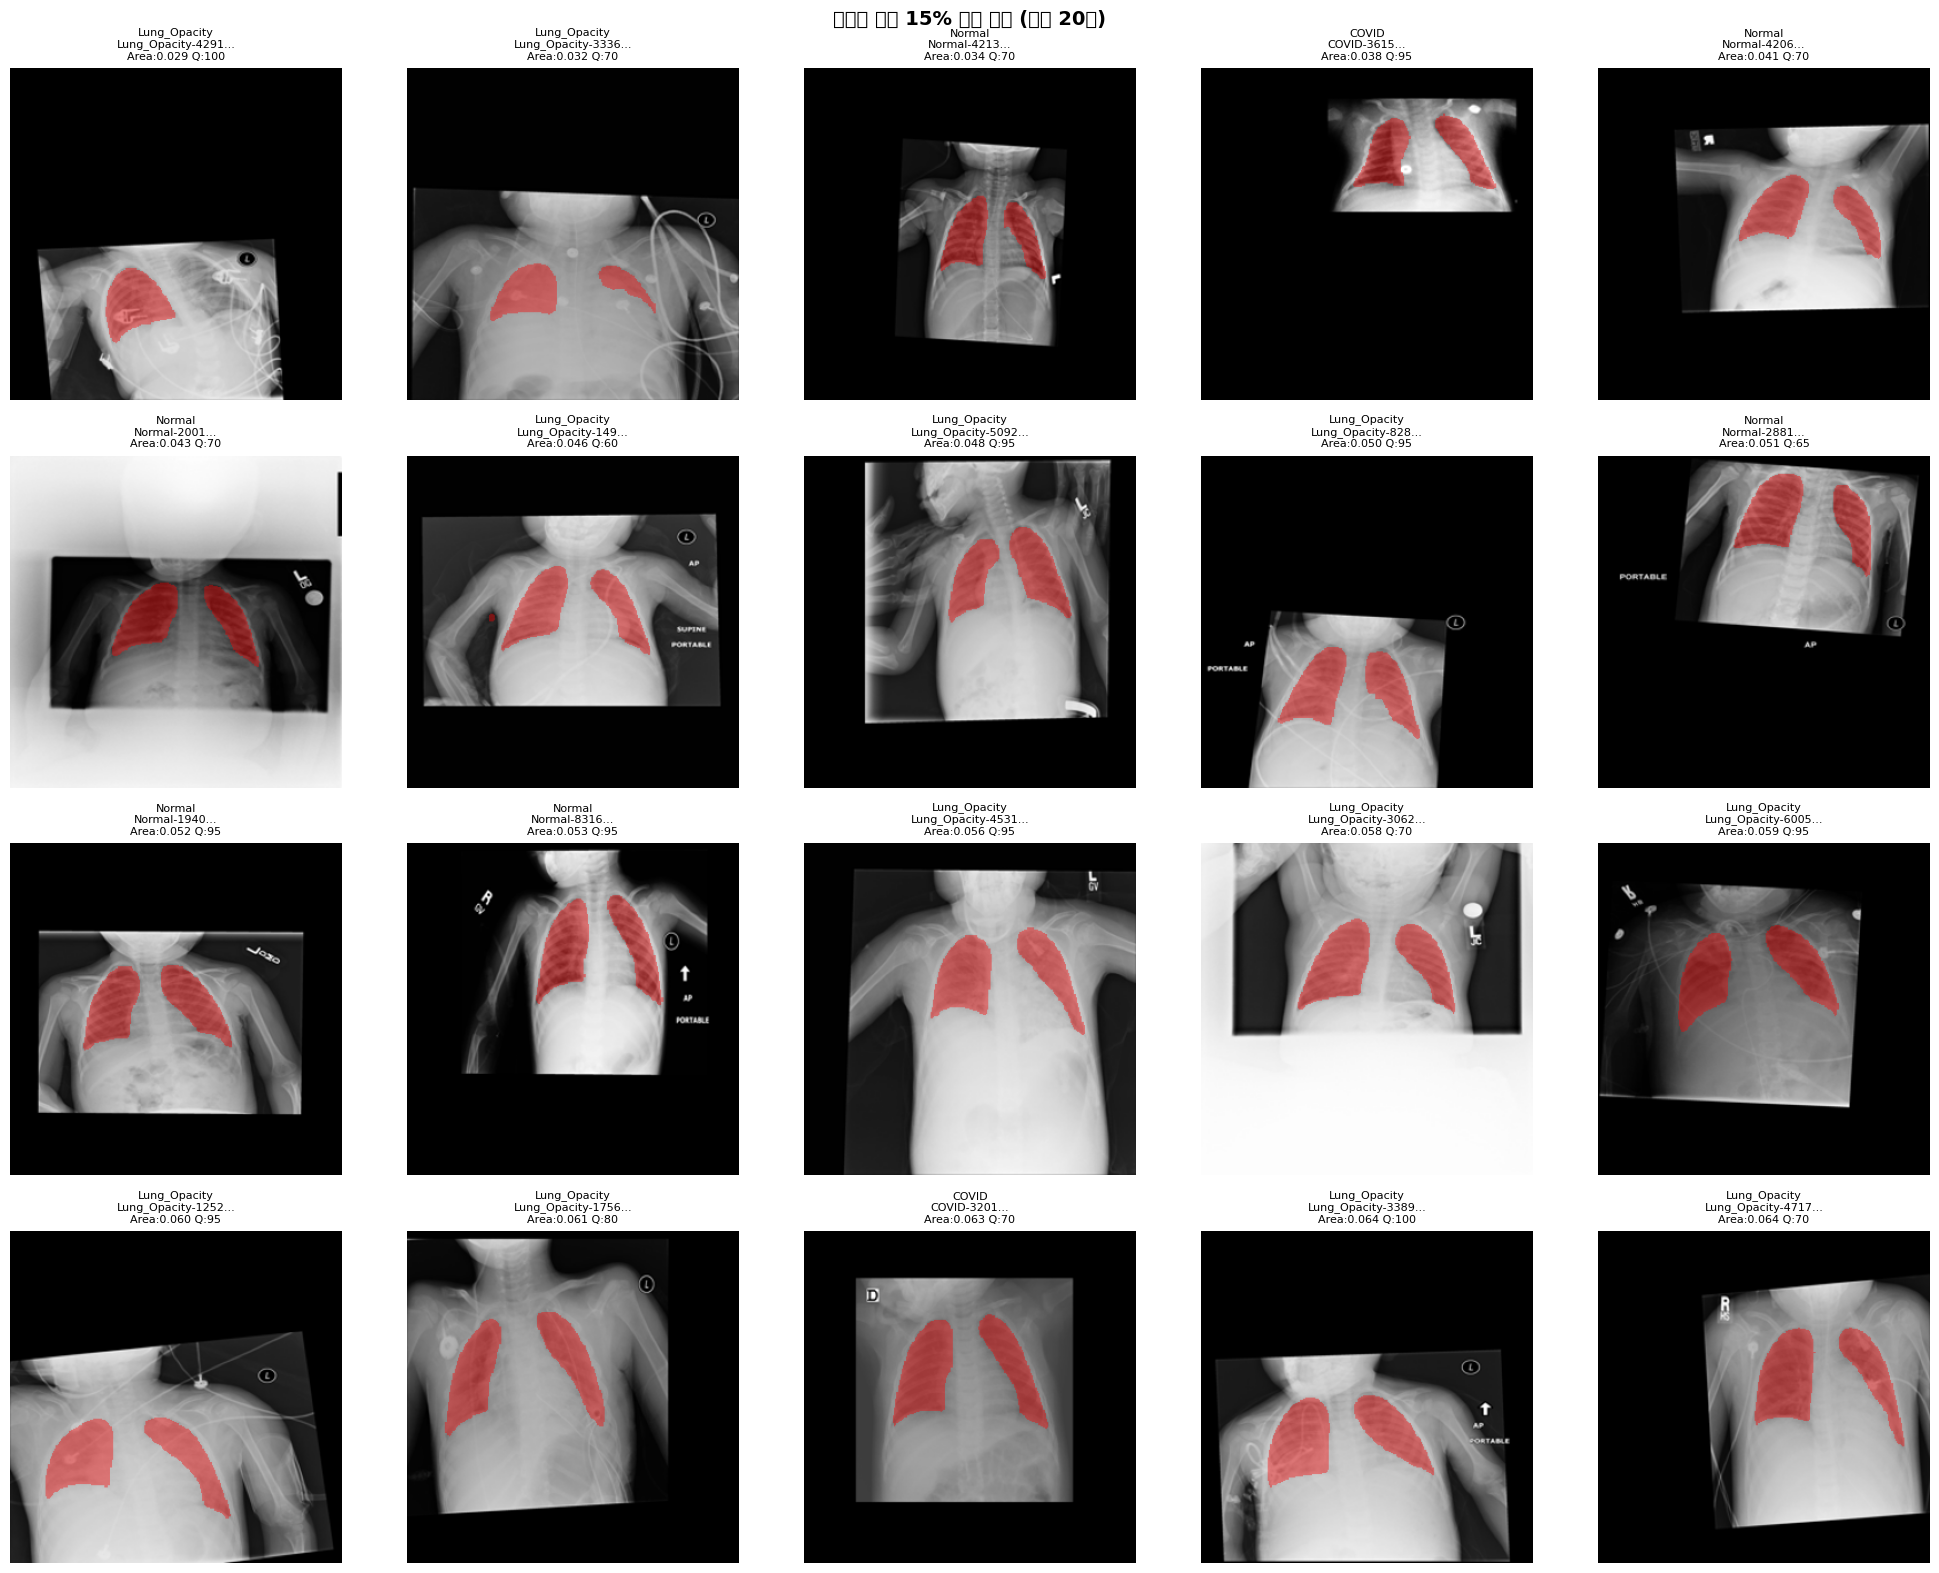

✓ 시각화 저장: small_mask_visualization.png


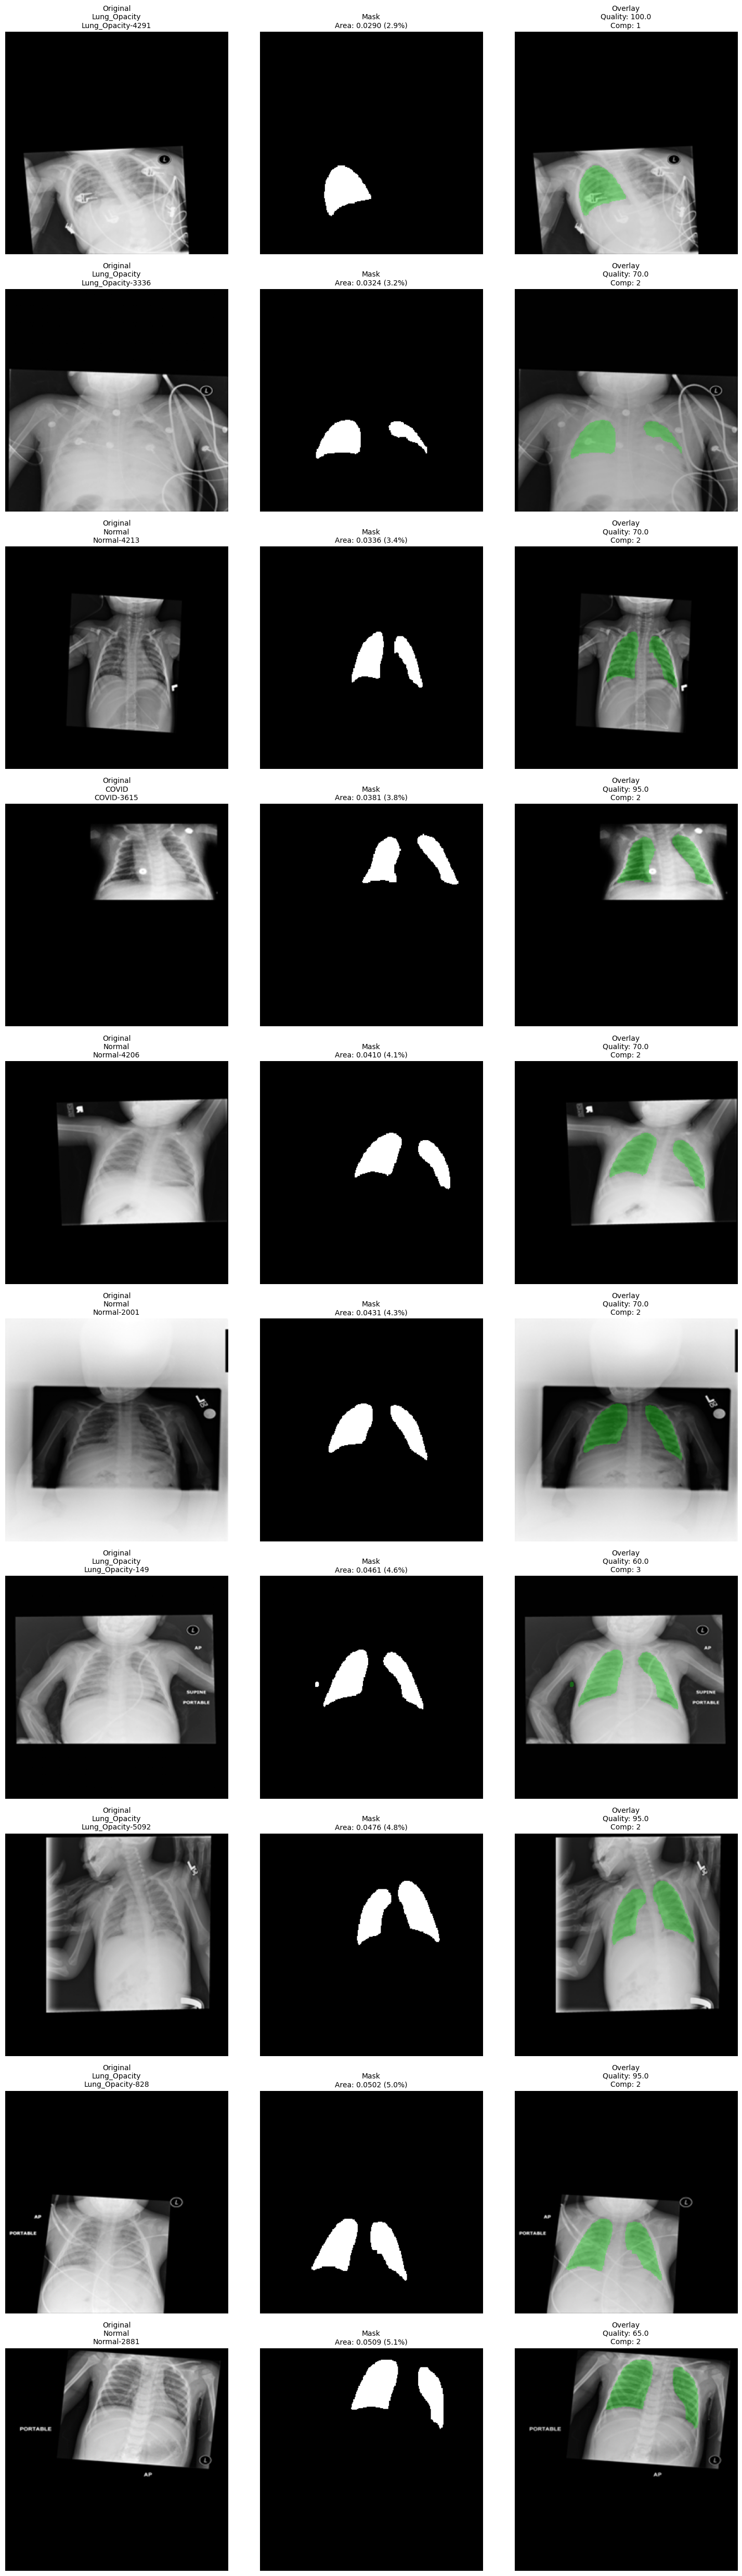

✓ 상세 시각화 저장: small_mask_detailed.png


In [41]:
def find_small_mask_samples(eda, threshold=0.15):
    """마스크 면적이 임계값 미만인 샘플 찾기 및 시각화"""
    df = eda.df_results
    
    # 면적이 threshold 미만인 샘플 필터링
    small_mask_samples = df[df['mask_area_ratio'] < threshold].sort_values('mask_area_ratio')
    
    print("="*60)
    print(f"마스크 면적 {threshold*100}% 미만 샘플 분석")
    print("="*60)
    print(f"\n총 개수: {len(small_mask_samples)}개 ({len(small_mask_samples)/len(df)*100:.2f}%)")
    
    # 클래스별 분포
    print("\n클래스별 분포:")
    class_dist = small_mask_samples['class'].value_counts()
    for class_name, count in class_dist.items():
        class_total = len(df[df['class'] == class_name])
        print(f"  {class_name}: {count}개 ({count/class_total*100:.2f}%)")
    
    # 통계
    print(f"\n면적 범위: {small_mask_samples['mask_area_ratio'].min():.4f} ~ {small_mask_samples['mask_area_ratio'].max():.4f}")
    print(f"평균 면적: {small_mask_samples['mask_area_ratio'].mean():.4f}")
    print(f"평균 품질 점수: {small_mask_samples['mask_quality_score'].mean():.1f}")
    
    # 파일명 리스트 출력
    print("\n" + "="*60)
    print("파일명 리스트 (면적 작은 순)")
    print("="*60)
    
    # ★★★ 전체 출력하도록 수정 ★★★
    for idx, row in small_mask_samples.iterrows():
        print(f"{row['class']:20s} {row['image_name']:40s} 면적:{row['mask_area_ratio']:.4f} 품질:{row['mask_quality_score']:.1f}")
    
    # 파일로 저장
    output_file = f'small_mask_samples_under_{int(threshold*100)}percent.txt'
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(f"마스크 면적 {threshold*100}% 미만 샘플\n")
        f.write("="*80 + "\n\n")
        
        for idx, row in small_mask_samples.iterrows():
            f.write(f"{row['class']}/{row['image_name']}.png\t")
            f.write(f"면적:{row['mask_area_ratio']:.4f}\t")
            f.write(f"품질:{row['mask_quality_score']:.1f}\t")
            f.write(f"컴포넌트:{row['num_components']}\n")
    
    print(f"\n✓ 전체 파일명 저장: {output_file}")
    
    return small_mask_samples


def visualize_small_masks(eda, small_mask_samples, max_show=20):
    """작은 마스크 샘플 시각화"""
    
    if len(small_mask_samples) == 0:
        print("시각화할 샘플이 없습니다.")
        return
    
    # 최대 max_show개만
    samples_to_show = small_mask_samples.head(max_show)
    
    print(f"\n{len(samples_to_show)}개 샘플 시각화 중...")
    
    # 4x5 그리드
    n_cols = 5
    n_rows = (len(samples_to_show) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    
    # ★★★ axes 처리 수정 ★★★
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    axes = axes.flatten()
    
    for idx, (_, sample) in enumerate(samples_to_show.iterrows()):
        if idx >= len(axes):
            break
        
        image, mask = eda.load_image_and_mask(sample['class'], sample['image_name'])
        
        if image is None or mask is None:
            axes[idx].text(0.5, 0.5, 'Load Failed', ha='center', va='center')
            axes[idx].axis('off')
            continue
        
        # 오버레이
        overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        overlay[mask > 0] = [255, 0, 0]
        blended = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), 0.6, overlay, 0.4, 0)
        
        axes[idx].imshow(blended)
        axes[idx].set_title(
            f"{sample['class']}\n"
            f"{sample['image_name'][:20]}...\n"
            f"Area:{sample['mask_area_ratio']:.3f} Q:{sample['mask_quality_score']:.0f}",
            fontsize=8
        )
        axes[idx].axis('off')
    
    # 빈 subplot 제거
    for idx in range(len(samples_to_show), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'마스크 면적 15% 미만 샘플 (상위 {len(samples_to_show)}개)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    output_file = 'small_mask_visualization.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ 시각화 저장: {output_file}")


def visualize_small_masks_detailed(eda, small_mask_samples, num_show=10):
    """작은 마스크 상세 시각화 (원본, 마스크, 오버레이 각각)"""
    
    if len(small_mask_samples) == 0:
        print("시각화할 샘플이 없습니다.")
        return
    
    samples_to_show = small_mask_samples.head(num_show)
    
    fig, axes = plt.subplots(len(samples_to_show), 3, figsize=(15, 5*len(samples_to_show)))
    
    # ★★★ axes 처리 수정 ★★★
    if len(samples_to_show) == 1:
        axes = axes.reshape(1, -1)
    
    for i, (_, sample) in enumerate(samples_to_show.iterrows()):
        image, mask = eda.load_image_and_mask(sample['class'], sample['image_name'])
        
        if image is None or mask is None:
            axes[i, 0].text(0.5, 0.5, 'Load Failed', ha='center', va='center')
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
            axes[i, 2].axis('off')
            continue
        
        # 오버레이
        overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        overlay[mask > 0] = [0, 255, 0]
        blended = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), 0.7, overlay, 0.3, 0)
        
        # 1. 원본
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'Original\n{sample["class"]}\n{sample["image_name"][:20]}', fontsize=10)
        axes[i, 0].axis('off')
        
        # 2. 마스크
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(
            f'Mask\nArea: {sample["mask_area_ratio"]:.4f} ({sample["mask_area_ratio"]*100:.1f}%)',
            fontsize=10
        )
        axes[i, 1].axis('off')
        
        # 3. 오버레이
        axes[i, 2].imshow(blended)
        axes[i, 2].set_title(
            f'Overlay\nQuality: {sample["mask_quality_score"]:.1f}\nComp: {sample["num_components"]}',
            fontsize=10
        )
        axes[i, 2].axis('off')
    
    plt.suptitle(f'마스크 면적 15% 미만 - 상위 {len(samples_to_show)}개 상세', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    output_file = 'small_mask_detailed.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ 상세 시각화 저장: {output_file}")


# 실행
small_samples = find_small_mask_samples(eda, threshold=0.15)

# 그리드 시각화
visualize_small_masks(eda, small_samples, max_show=20)

# 상세 시각화
visualize_small_masks_detailed(eda, small_samples, num_show=10)

# 중복 검사

In [2]:
import hashlib
from collections import defaultdict
from tqdm import tqdm

def check_duplicate_images_by_hash(root_dir):
    """파일 해시 기반 완전 중복 이미지 검사"""
    
    print("="*60)
    print("이미지 중복 검사 (파일 해시 기반)")
    print("="*60)
    
    hash_dict = defaultdict(list)
    classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    total_files = 0
    
    # 모든 이미지의 해시 계산
    for class_name in classes:
        img_folder = os.path.join(root_dir, class_name, 'images')
        
        if not os.path.exists(img_folder):
            print(f"⚠ 폴더 없음: {img_folder}")
            continue
        
        img_files = [f for f in os.listdir(img_folder) if f.endswith('.png')]
        print(f"\n[{class_name}] {len(img_files)}개 파일 처리 중...")
        
        for img_file in tqdm(img_files, desc=f"  {class_name}"):
            img_path = os.path.join(img_folder, img_file)
            
            try:
                # MD5 해시 계산
                with open(img_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                
                hash_dict[file_hash].append({
                    'class': class_name,
                    'filename': img_file.replace('.png', ''),
                    'path': img_path
                })
                
                total_files += 1
            except Exception as e:
                print(f"    ✗ 오류: {img_file} - {str(e)}")
    
    # 중복 찾기
    duplicates = {k: v for k, v in hash_dict.items() if len(v) > 1}
    
    print("\n" + "="*60)
    print("중복 검사 결과")
    print("="*60)
    print(f"총 파일 수: {total_files:,}개")
    print(f"고유 파일 수: {len(hash_dict):,}개")
    print(f"중복 그룹 수: {len(duplicates)}개")
    
    if len(duplicates) > 0:
        total_duplicate_files = sum(len(v) for v in duplicates.values()) - len(duplicates)
        print(f"중복 파일 수: {total_duplicate_files}개 ({total_duplicate_files/total_files*100:.2f}%)")
        
        print("\n" + "="*60)
        print("중복 그룹 상세")
        print("="*60)
        
        for idx, (hash_val, files) in enumerate(duplicates.items(), 1):
            print(f"\n[중복 그룹 {idx}] {len(files)}개 파일")
            for file_info in files:
                print(f"  - {file_info['class']:20s} {file_info['filename']}")
            
            if idx >= 10:  # 처음 10개 그룹만 출력
                remaining = len(duplicates) - 10
                if remaining > 0:
                    print(f"\n... 외 {remaining}개 중복 그룹")
                break
        
        # 파일로 저장
        save_duplicate_report(duplicates, 'duplicate_images_report.txt')
        
    else:
        print("✓ 중복 이미지 없음!")
    
    return duplicates


def save_duplicate_report(duplicates, output_file):
    """중복 리포트 파일 저장"""
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("이미지 중복 검사 리포트\n")
        f.write("="*80 + "\n\n")
        f.write(f"총 중복 그룹 수: {len(duplicates)}개\n\n")
        
        for idx, (hash_val, files) in enumerate(duplicates.items(), 1):
            f.write(f"[중복 그룹 {idx}] {len(files)}개 파일 (Hash: {hash_val})\n")
            
            for file_info in files:
                f.write(f"  {file_info['class']}/{file_info['filename']}.png\n")
            
            f.write("\n")
        
        # 제거 권장 목록 (첫 번째 제외)
        f.write("\n" + "="*80 + "\n")
        f.write("제거 권장 파일 목록 (각 그룹의 첫 번째는 유지)\n")
        f.write("="*80 + "\n\n")
        
        for files in duplicates.values():
            for file_info in files[1:]:  # 첫 번째 제외
                f.write(f"{file_info['class']}/{file_info['filename']}.png\n")
    
    print(f"\n✓ 리포트 저장: {output_file}")

이미지 중복 검사 (파일 해시 기반)

[COVID] 3616개 파일 처리 중...


  COVID: 100%|██████████| 3616/3616 [00:00<00:00, 10199.55it/s]



[Lung_Opacity] 6012개 파일 처리 중...


  Lung_Opacity: 100%|██████████| 6012/6012 [00:00<00:00, 8939.65it/s] 



[Normal] 10192개 파일 처리 중...


  Normal: 100%|██████████| 10192/10192 [00:00<00:00, 11514.53it/s]



[Viral Pneumonia] 1345개 파일 처리 중...


  Viral Pneumonia: 100%|██████████| 1345/1345 [00:00<00:00, 10752.45it/s]



중복 검사 결과
총 파일 수: 21,165개
고유 파일 수: 21,111개
중복 그룹 수: 42개
중복 파일 수: 54개 (0.26%)

중복 그룹 상세

[중복 그룹 1] 2개 파일
  - COVID                COVID-3223
  - COVID                COVID-3222

[중복 그룹 2] 2개 파일
  - COVID                COVID-2823
  - COVID                COVID-2822

[중복 그룹 3] 2개 파일
  - COVID                COVID-3488
  - COVID                COVID-3489

[중복 그룹 4] 3개 파일
  - COVID                COVID-2773
  - COVID                COVID-2774
  - COVID                COVID-2772

[중복 그룹 5] 2개 파일
  - COVID                COVID-2941
  - COVID                COVID-2942

[중복 그룹 6] 2개 파일
  - COVID                COVID-2458
  - COVID                COVID-2459

[중복 그룹 7] 2개 파일
  - COVID                COVID-2666
  - COVID                COVID-2667

[중복 그룹 8] 5개 파일
  - COVID                COVID-3142
  - COVID                COVID-3141
  - COVID                COVID-3143
  - COVID                COVID-3140
  - COVID                COVID-3144

[중복 그룹 9] 2개 파일
  - COVID                COVID-2805
  - 

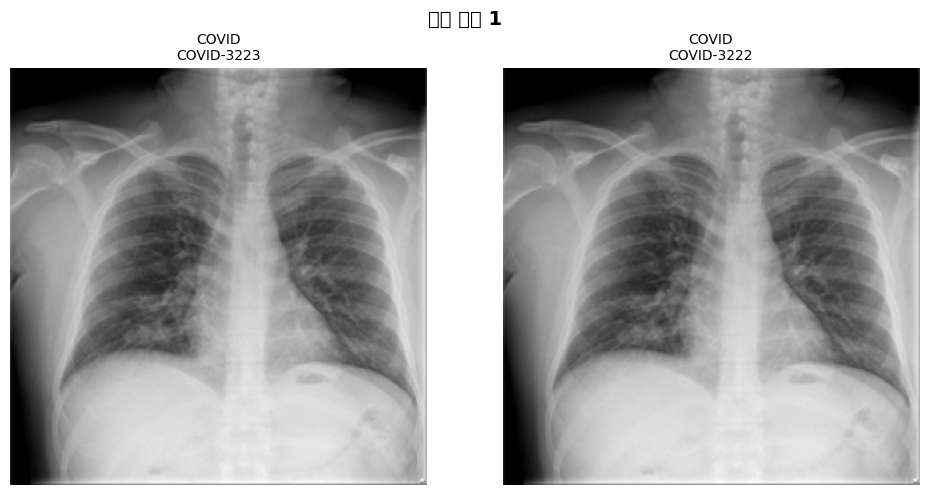

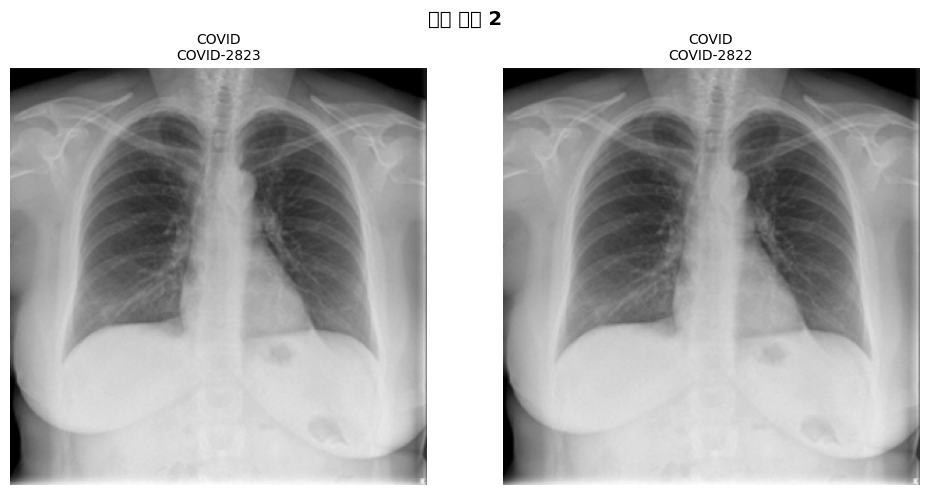

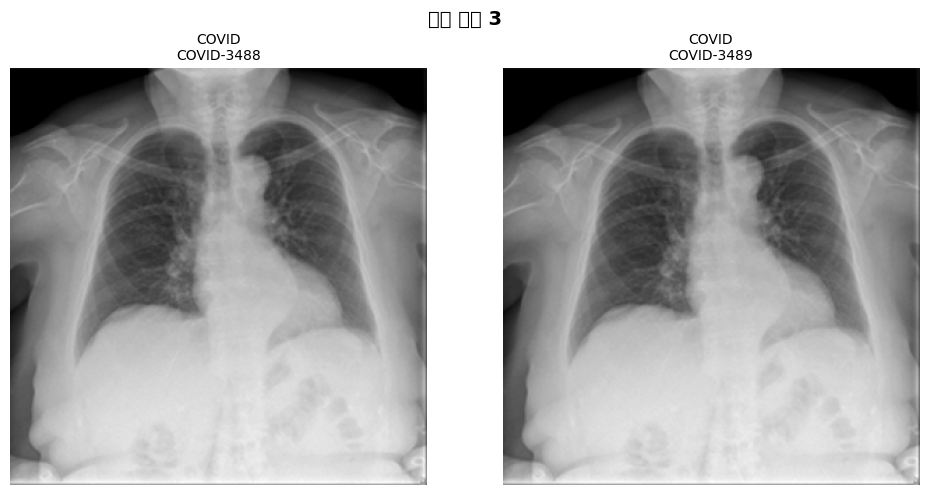

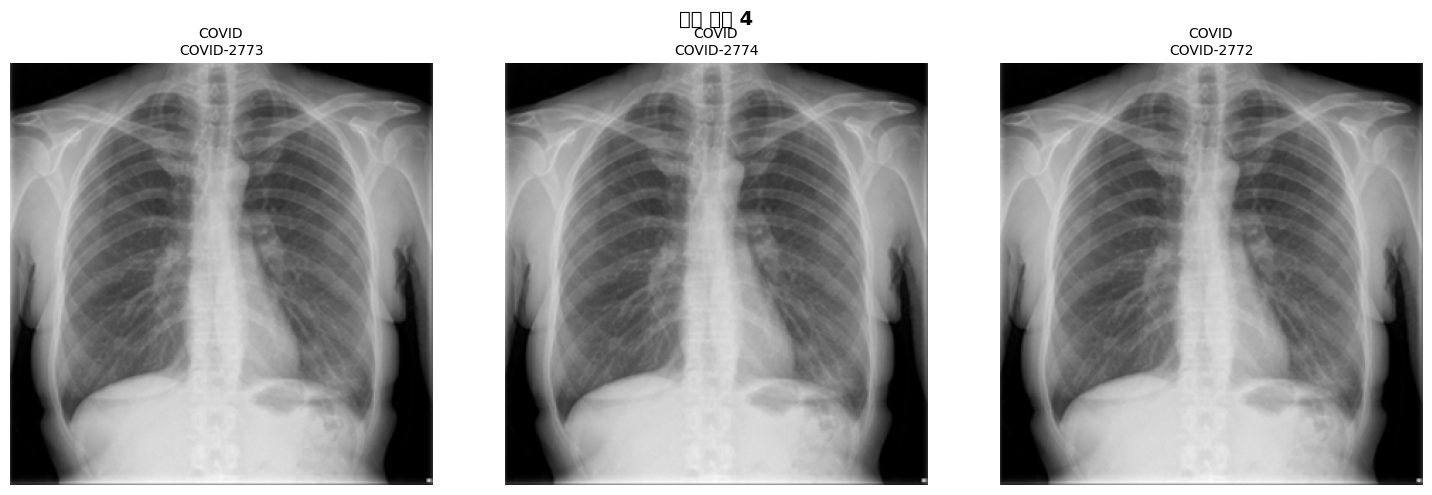

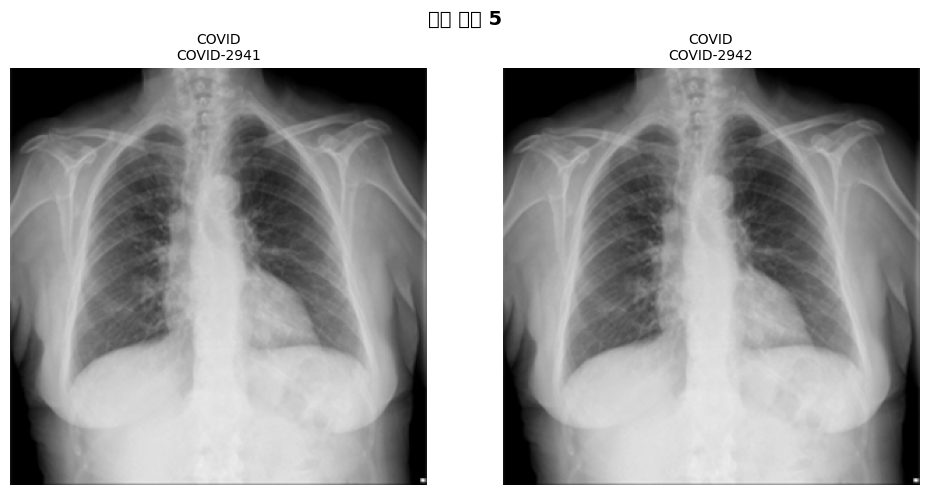

✓ 5개 중복 그룹 시각화 완료


In [44]:
duplicates = check_duplicate_images_by_hash(root_dir)

def visualize_duplicates(duplicates, eda, max_groups=5):
    """중복 그룹 시각화"""
    
    if len(duplicates) == 0:
        print("시각화할 중복 그룹이 없습니다.")
        return
    
    groups_to_show = list(duplicates.values())[:max_groups]
    
    for group_idx, files in enumerate(groups_to_show, 1):
        n_files = len(files)
        
        fig, axes = plt.subplots(1, n_files, figsize=(5*n_files, 5))
        
        if n_files == 1:
            axes = [axes]
        
        for idx, file_info in enumerate(files):
            img_path = file_info['path']
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(
                    f"{file_info['class']}\n{file_info['filename'][:20]}",
                    fontsize=10
                )
                axes[idx].axis('off')
        
        plt.suptitle(f'중복 그룹 {group_idx}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'duplicate_group_{group_idx}.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print(f"✓ {len(groups_to_show)}개 중복 그룹 시각화 완료")

# 2. 시각화
if len(duplicates) > 0:
    visualize_duplicates(duplicates, eda, max_groups=5)

이미지 중복 검사 (파일 해시 기반)

[COVID] 3616개 파일 처리 중...


  COVID: 100%|██████████| 3616/3616 [00:00<00:00, 10166.09it/s]



[Lung_Opacity] 6012개 파일 처리 중...


  Lung_Opacity: 100%|██████████| 6012/6012 [00:00<00:00, 11870.21it/s]



[Normal] 10192개 파일 처리 중...


  Normal: 100%|██████████| 10192/10192 [00:00<00:00, 11593.76it/s]



[Viral Pneumonia] 1521개 파일 처리 중...


  Viral Pneumonia: 100%|██████████| 1521/1521 [00:00<00:00, 6127.75it/s]



중복 검사 결과
총 파일 수: 21,341개
고유 파일 수: 21,287개
중복 그룹 수: 42개
중복 파일 수: 54개 (0.25%)

중복 그룹 상세

[중복 그룹 1] 2개 파일
  - COVID                COVID-3223
  - COVID                COVID-3222

[중복 그룹 2] 2개 파일
  - COVID                COVID-2823
  - COVID                COVID-2822

[중복 그룹 3] 2개 파일
  - COVID                COVID-3488
  - COVID                COVID-3489

[중복 그룹 4] 3개 파일
  - COVID                COVID-2773
  - COVID                COVID-2774
  - COVID                COVID-2772

[중복 그룹 5] 2개 파일
  - COVID                COVID-2941
  - COVID                COVID-2942

[중복 그룹 6] 2개 파일
  - COVID                COVID-2458
  - COVID                COVID-2459

[중복 그룹 7] 2개 파일
  - COVID                COVID-2666
  - COVID                COVID-2667

[중복 그룹 8] 5개 파일
  - COVID                COVID-3142
  - COVID                COVID-3141
  - COVID                COVID-3143
  - COVID                COVID-3140
  - COVID                COVID-3144

[중복 그룹 9] 2개 파일
  - COVID                COVID-2805
  - 

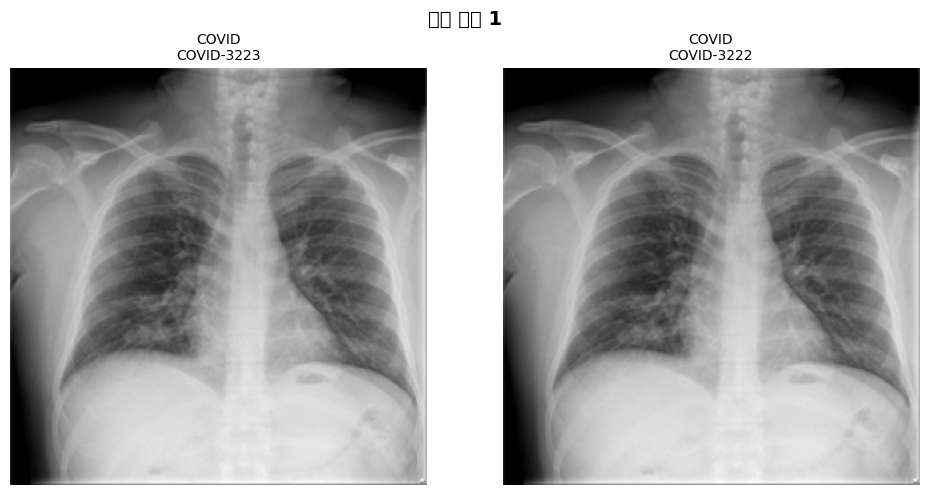

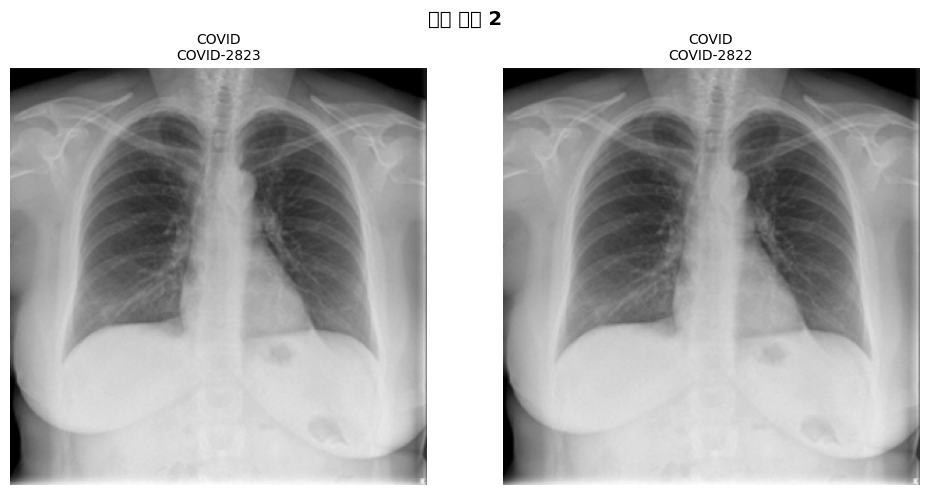

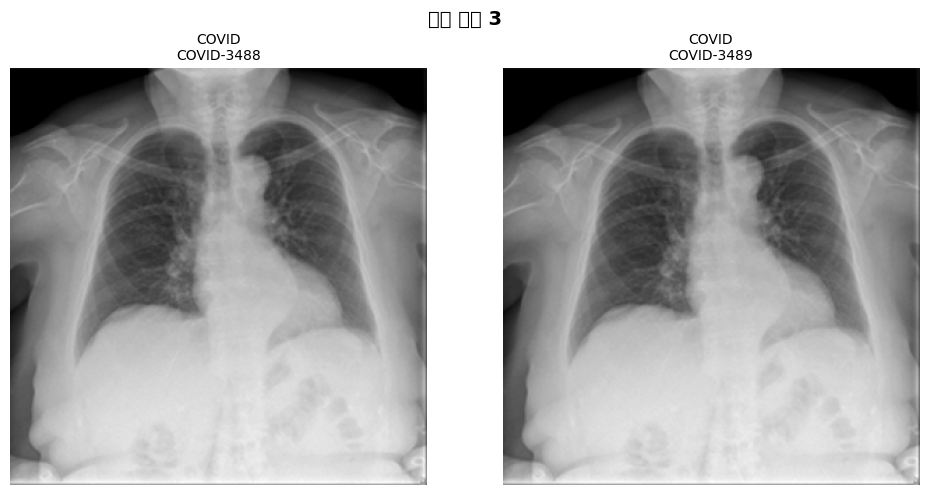

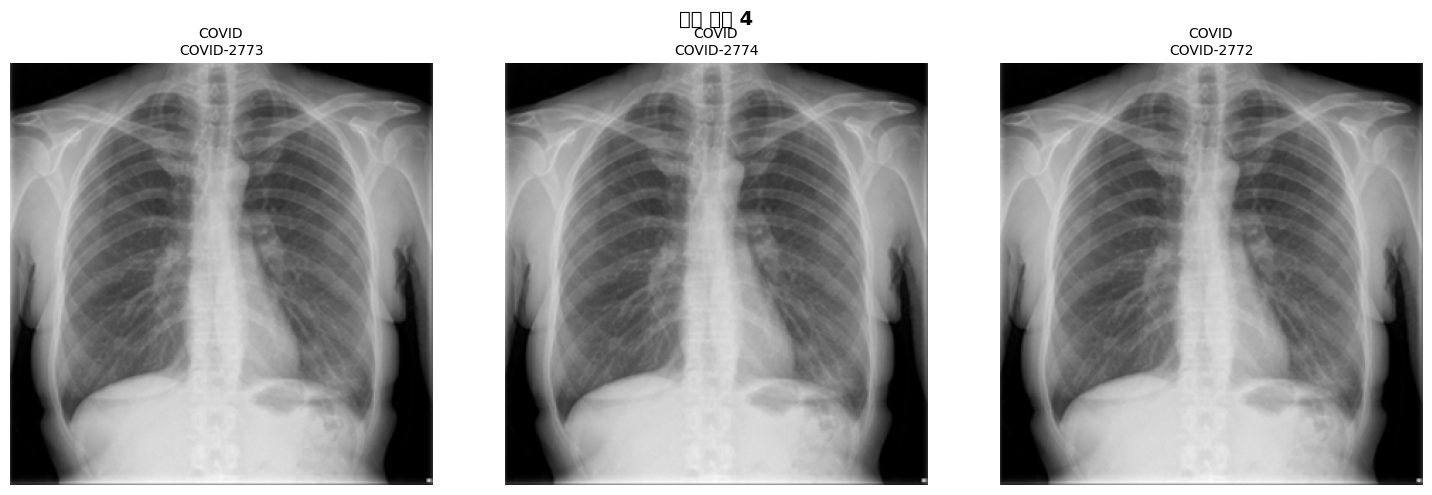

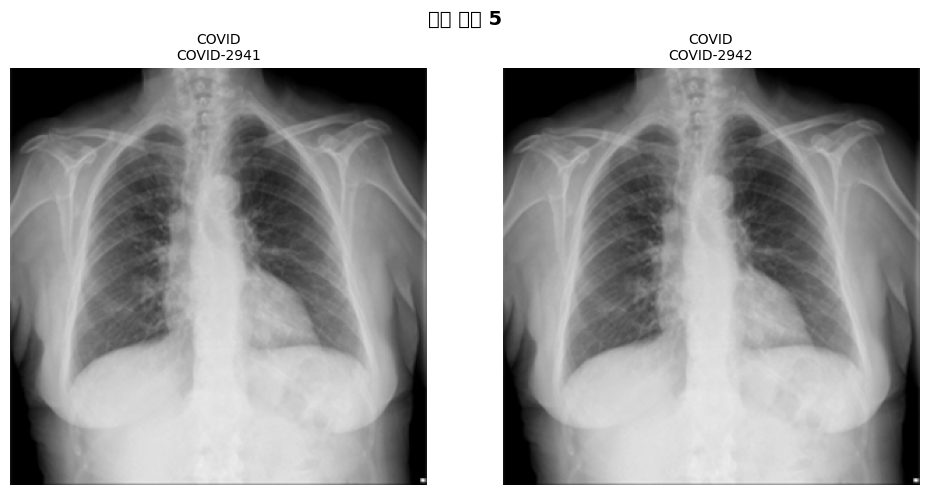

✓ 5개 중복 그룹 시각화 완료


In [7]:
import os
root_dir = './COVID-19_Radiography_Dataset'
duplicates = check_duplicate_images_by_hash(root_dir)

def visualize_duplicates(duplicates, eda, max_groups=5):
    """중복 그룹 시각화"""
    
    if len(duplicates) == 0:
        print("시각화할 중복 그룹이 없습니다.")
        return
    
    groups_to_show = list(duplicates.values())[:max_groups]
    
    for group_idx, files in enumerate(groups_to_show, 1):
        n_files = len(files)
        
        fig, axes = plt.subplots(1, n_files, figsize=(5*n_files, 5))
        
        if n_files == 1:
            axes = [axes]
        
        for idx, file_info in enumerate(files):
            img_path = file_info['path']
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(
                    f"{file_info['class']}\n{file_info['filename'][:20]}",
                    fontsize=10
                )
                axes[idx].axis('off')
        
        plt.suptitle(f'중복 그룹 {group_idx}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'duplicate_group_{group_idx}.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print(f"✓ {len(groups_to_show)}개 중복 그룹 시각화 완료")

# 2. 시각화
if len(duplicates) > 0:
    visualize_duplicates(duplicates, eda, max_groups=5)

In [11]:
import os
import shutil
from pathlib import Path

def remove_duplicates(duplicates, keep='first', backup=True, backup_dir='./duplicate_backup'):
    """
    중복 이미지 중 하나만 남기고 나머지 삭제
    
    Parameters:
    -----------
    duplicates : dict
        check_duplicate_images_by_hash()의 반환값
    keep : str
        'first' - 첫 번째 파일 유지
        'last' - 마지막 파일 유지
        'shortest_path' - 경로가 가장 짧은 파일 유지
    backup : bool
        삭제 전 백업 여부
    backup_dir : str
        백업 디렉토리 경로
    
    Returns:
    --------
    dict : 삭제 결과 통계
    """
    
    if len(duplicates) == 0:
        print("삭제할 중복 파일이 없습니다.")
        return {'deleted': 0, 'kept': 0, 'errors': []}
    
    # 백업 디렉토리 생성
    if backup:
        Path(backup_dir).mkdir(parents=True, exist_ok=True)
        print(f"백업 디렉토리: {backup_dir}")
    
    deleted_count = 0
    kept_count = 0
    errors = []
    
    for hash_value, files in duplicates.items():
        if len(files) < 2:
            continue
        
        # 유지할 파일 선택
        if keep == 'first':
            file_to_keep = files[0]
            files_to_delete = files[1:]
        elif keep == 'last':
            file_to_keep = files[-1]
            files_to_delete = files[:-1]
        elif keep == 'shortest_path':
            files_sorted = sorted(files, key=lambda x: len(x['path']))
            file_to_keep = files_sorted[0]
            files_to_delete = files_sorted[1:]
        else:
            raise ValueError(f"Invalid keep option: {keep}")
        
        print(f"\n[유지] {file_to_keep['path']}")
        kept_count += 1
        
        # 중복 파일 삭제
        for file_info in files_to_delete:
            file_path = file_info['path']
            
            try:
                # 백업
                if backup:
                    backup_path = os.path.join(
                        backup_dir, 
                        f"{file_info['class']}_{file_info['filename']}"
                    )
                    # 백업 파일명 중복 방지
                    counter = 1
                    original_backup_path = backup_path
                    while os.path.exists(backup_path):
                        name, ext = os.path.splitext(original_backup_path)
                        backup_path = f"{name}_{counter}{ext}"
                        counter += 1
                    
                    shutil.copy2(file_path, backup_path)
                
                # 삭제
                os.remove(file_path)
                print(f"  [삭제] {file_path}")
                deleted_count += 1
                
            except Exception as e:
                error_msg = f"Error deleting {file_path}: {str(e)}"
                print(f"  [오류] {error_msg}")
                errors.append(error_msg)
    
    # 결과 출력
    print("\n" + "="*60)
    print("중복 제거 완료!")
    print(f"✓ 유지된 파일: {kept_count}개")
    print(f"✓ 삭제된 파일: {deleted_count}개")
    if backup:
        print(f"✓ 백업 위치: {backup_dir}")
    if errors:
        print(f"⚠ 오류 발생: {len(errors)}개")
    print("="*60)
    
    return {
        'deleted': deleted_count,
        'kept': kept_count,
        'errors': errors
    }


def preview_deletion(duplicates, keep='first', max_groups=5):
    """삭제 미리보기 (실제 삭제하지 않음)"""
    
    if len(duplicates) == 0:
        print("중복 파일이 없습니다.")
        return
    
    print("\n[삭제 미리보기]")
    print("="*60)
    
    groups_shown = 0
    total_to_delete = 0
    total_to_keep = 0
    
    for hash_value, files in duplicates.items():
        if len(files) < 2:
            continue
        
        if groups_shown >= max_groups:
            break
        
        groups_shown += 1
        
        # 유지할 파일 선택
        if keep == 'first':
            file_to_keep = files[0]
            files_to_delete = files[1:]
        elif keep == 'last':
            file_to_keep = files[-1]
            files_to_delete = files[:-1]
        elif keep == 'shortest_path':
            files_sorted = sorted(files, key=lambda x: len(x['path']))
            file_to_keep = files_sorted[0]
            files_to_delete = files_sorted[1:]
        
        print(f"\n그룹 {groups_shown}:")
        print(f"  [유지] {file_to_keep['path']}")
        total_to_keep += 1
        
        for file_info in files_to_delete:
            print(f"  [삭제] {file_info['path']}")
            total_to_delete += 1
    
    # 전체 통계
    all_to_delete = sum(len(files) - 1 for files in duplicates.values() if len(files) > 1)
    all_to_keep = len(duplicates)
    
    print("\n" + "="*60)
    print(f"전체 통계:")
    print(f"  - 중복 그룹: {len(duplicates)}개")
    print(f"  - 유지될 파일: {all_to_keep}개")
    print(f"  - 삭제될 파일: {all_to_delete}개")
    print("="*60)

In [12]:
# 1. 먼저 중복 파일 확인
duplicates = check_duplicate_images_by_hash(root_dir)

# 2. 삭제 미리보기 (실제로 삭제하지 않음)
preview_deletion(duplicates, keep='first', max_groups=10)

# 3. 실제 삭제 (백업 포함)
result = remove_duplicates(
    duplicates, 
    keep='first',           # 'first', 'last', 'shortest_path' 중 선택
    backup=True,            # 백업 여부
    backup_dir='./backup'   # 백업 경로
)

# 4. 백업 없이 삭제 (주의!)
# result = remove_duplicates(duplicates, keep='first', backup=False)

이미지 중복 검사 (파일 해시 기반)

[COVID] 3616개 파일 처리 중...


  COVID: 100%|██████████| 3616/3616 [00:05<00:00, 627.87it/s]



[Lung_Opacity] 6012개 파일 처리 중...


  Lung_Opacity: 100%|██████████| 6012/6012 [00:09<00:00, 640.04it/s]



[Normal] 10192개 파일 처리 중...


  Normal: 100%|██████████| 10192/10192 [00:16<00:00, 624.14it/s]



[Viral Pneumonia] 1521개 파일 처리 중...


  Viral Pneumonia: 100%|██████████| 1521/1521 [00:03<00:00, 506.68it/s]



중복 검사 결과
총 파일 수: 21,341개
고유 파일 수: 21,287개
중복 그룹 수: 42개
중복 파일 수: 54개 (0.25%)

중복 그룹 상세

[중복 그룹 1] 2개 파일
  - COVID                COVID-3223
  - COVID                COVID-3222

[중복 그룹 2] 2개 파일
  - COVID                COVID-2823
  - COVID                COVID-2822

[중복 그룹 3] 2개 파일
  - COVID                COVID-3488
  - COVID                COVID-3489

[중복 그룹 4] 3개 파일
  - COVID                COVID-2773
  - COVID                COVID-2774
  - COVID                COVID-2772

[중복 그룹 5] 2개 파일
  - COVID                COVID-2941
  - COVID                COVID-2942

[중복 그룹 6] 2개 파일
  - COVID                COVID-2458
  - COVID                COVID-2459

[중복 그룹 7] 2개 파일
  - COVID                COVID-2666
  - COVID                COVID-2667

[중복 그룹 8] 5개 파일
  - COVID                COVID-3142
  - COVID                COVID-3141
  - COVID                COVID-3143
  - COVID                COVID-3140
  - COVID                COVID-3144

[중복 그룹 9] 2개 파일
  - COVID                COVID-2805
  - 

In [24]:
import os
root_dir = './COVID-19_Radiography_Dataset'
duplicates = check_duplicate_images_by_hash(root_dir)

def visualize_duplicates(duplicates, eda, max_groups=5):
    """중복 그룹 시각화"""
    
    if len(duplicates) == 0:
        print("시각화할 중복 그룹이 없습니다.")
        return
    
    groups_to_show = list(duplicates.values())[:max_groups]
    
    for group_idx, files in enumerate(groups_to_show, 1):
        n_files = len(files)
        
        fig, axes = plt.subplots(1, n_files, figsize=(5*n_files, 5))
        
        if n_files == 1:
            axes = [axes]
        
        for idx, file_info in enumerate(files):
            img_path = file_info['path']
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(
                    f"{file_info['class']}\n{file_info['filename'][:20]}",
                    fontsize=10
                )
                axes[idx].axis('off')
        
        plt.suptitle(f'중복 그룹 {group_idx}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'duplicate_group_{group_idx}.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print(f"✓ {len(groups_to_show)}개 중복 그룹 시각화 완료")

# 2. 시각화
if len(duplicates) > 0:
    visualize_duplicates(duplicates, eda, max_groups=5)

이미지 중복 검사 (파일 해시 기반)

[COVID] 3569개 파일 처리 중...


  COVID: 100%|██████████| 3569/3569 [00:00<00:00, 9487.94it/s]



[Lung_Opacity] 6011개 파일 처리 중...


  Lung_Opacity: 100%|██████████| 6011/6011 [00:00<00:00, 11469.87it/s]



[Normal] 10190개 파일 처리 중...


  Normal: 100%|██████████| 10190/10190 [00:00<00:00, 11100.08it/s]



[Viral Pneumonia] 1514개 파일 처리 중...


  Viral Pneumonia: 100%|██████████| 1514/1514 [00:00<00:00, 5825.33it/s]


중복 검사 결과
총 파일 수: 21,284개
고유 파일 수: 21,284개
중복 그룹 수: 0개
✓ 중복 이미지 없음!


# 파일 내용 정렬

In [20]:
# 파일 읽기
with open("./segmentation_eda_results/abnormal_components_COVID_list.txt", "r") as f:
    lines = f.read().splitlines()

# 정렬 (숫자 기준 정렬)
sorted_lines = sorted(lines, key=lambda x: int(x.split("-")[1]))

# 결과 저장
with open("./segmentation_eda_results/abnormal_components_COVID_list_sorted.txt", "w") as f:
    for line in sorted_lines:
        f.write(line + "\n")

print("정렬 완료! → covid_ids_sorted.txt 저장됨")


정렬 완료! → covid_ids_sorted.txt 저장됨


In [22]:
# 파일 읽기
with open("./segmentation_eda_results/abnormal_components_Lung_Opacity_list.txt", "r") as f:
    lines = f.read().splitlines()

# 정렬 (숫자 기준 정렬)
sorted_lines = sorted(lines, key=lambda x: int(x.split("-")[1]))

# 결과 저장
with open("./segmentation_eda_results/abnormal_components_Lung_Opacity_list_sorted.txt", "w") as f:
    for line in sorted_lines:
        f.write(line + "\n")

print("정렬 완료! → covid_ids_sorted.txt 저장됨")


정렬 완료! → covid_ids_sorted.txt 저장됨


In [ ]:
# 파일 읽기
with open("./segmentation_eda_results/abnormal_components_Normal_list.txt", "r") as f:
    lines = f.read().splitlines()

# 정렬 (숫자 기준 정렬)
sorted_lines = sorted(lines, key=lambda x: int(x.split("-")[1]))

# 결과 저장
with open("./segmentation_eda_results/abnormal_components_Normal_list_sorted.txt", "w") as f:
    for line in sorted_lines:
        f.write(line + "\n")

print("정렬 완료! → covid_ids_sorted.txt 저장됨")

In [23]:
# 파일 읽기
with open("./segmentation_eda_results/abnormal_components_Viral Pneumonia_list.txt", "r") as f:
    lines = f.read().splitlines()

# 정렬 (숫자 기준 정렬)
sorted_lines = sorted(lines, key=lambda x: int(x.split("-")[1]))

# 결과 저장
with open("./segmentation_eda_results/abnormal_components_Viral Pneumonia_list_sorted.txt", "w") as f:
    for line in sorted_lines:
        f.write(line + "\n")

print("정렬 완료! → covid_ids_sorted.txt 저장됨")

정렬 완료! → covid_ids_sorted.txt 저장됨
